In [1]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

# do PCA (and projective PCA?)
# todo: for each name look at its PCA (make a colored graph for different components?)
# train projection from PCA space to classifier space?

from mamba_lens import HookedMamba # this will take a little while to import
import torch
model_path = "state-spaces/mamba-370m"
model = HookedMamba.from_pretrained(model_path, device='cuda')
torch.set_grad_enabled(False)
            

/opt/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [10]:
# remember to do
# pip install -e .
# in the root directory of this repo
# also
# to install graphviz:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 10000
seed = 27
valid_seed = 28
constrain_to_answers = True
has_symmetric_patching = True

from acdc.data.ioi import BABA_TEMPLATES
#templates = [BABA_TEMPLATES[1]]
templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())
'''
patching_formats = [
    'AB A B\nAC A C', # 85, 
    #'AB A B\nCB C B', # 66
    #'AB B A\nAC C A', # 74
    #'AB B A\nCB B C' # 85
]
'''



data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)



In [6]:

from mamba_lens.input_dependent_hooks import clean_hooks
from acdc import accuracy_metric
from acdc import ACDCEvalData
from acdc import get_pad_token
import itertools
import copy
from collections import defaultdict
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from tqdm import tqdm
'''
patching_formats = [
    'AB A B\nAC A C', # 85, 
    #'AB A B\nCB C B', # 66 bad, need to change the output
    #'AB B A\nAC C A', # 74 bad, need to change the output
    'AB B A\nCB B C' # 85
]
'''
patching_formats = list(get_all_single_name_abc_patching_formats())
templates = ABC_TEMPLATES

model_kwargs = {
    "fast_ssm": True,
    "fast_conv": False,
}

all_important_layers = defaultdict(lambda: defaultdict(lambda: []))
#patching_formats = list(get_all_single_name_abc_patching_formats())
scores = torch.zeros([len(templates), len(patching_formats)])
template_to_i = dict([(t,i) for (i,t) in enumerate(templates)])
patching_to_i = dict([(t,i) for (i,t) in enumerate(patching_formats)])

num_patching_pairs = 200
#limited_layers  = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
limited_layers = list(range(model.cfg.n_layers))

def patch_layer_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B E N"]:
    # patch in corrupted (they come in pairs)
    for i in range(0, h.size()[0], 2):
        h[i] = h[i+1]
    return h

def hooks_to_remove_token_cross_talk(layers):
    # remove conv cross talk
    hooks = []
    
    for layer in layers:
        L = data.data.size()[1]
        hooks.append((f"blocks.{layer}.hook_conv", patch_layer_hook))
        #for l in range(L):
        #    hooks.append((f"blocks.{layer}.hook_h.{l}", patch_layer_hook))
    return hooks

for template, patching_format in itertools.product(templates, patching_formats):
    
    data = generate_dataset(model=model,
                      data_generator=ioi_data_generator,
                      num_patching_pairs=num_patching_pairs,
                      seed=seed,
                      valid_seed=valid_seed,
                      constrain_to_answers=constrain_to_answers,
                      has_symmetric_patching=has_symmetric_patching, 
                      varying_data_lengths=True,
                      templates=[template],
                      patching_formats=[patching_format])
    
    clean_hooks(model)
    def top_is_correct_metric(data: ACDCEvalData):
        return data.patched.top_is_correct
    #limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
    from functools import partial
    def wrap_run_with_hooks(model, fwd_hooks, bwd_hooks=[], **kwargs):
        '''
        Makes a fake object that acts like model
        but when you call it it'll actually call run_with_hooks with the provided hooks
        '''
        def wrapper(input, fwd_hooks, bwd_hooks):
            #print(f"running model with {len(fwd_hooks)} fwd hooks and {len(bwd_hooks)} bwd hooks")
            return model.run_with_hooks(input, only_use_these_layers=limited_layers, fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks, **kwargs)
        wrapper_with_hooks = partial(wrapper, fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks)
        wrapper_with_hooks.tokenizer = model.tokenizer
        wrapper_with_hooks.cfg = model.cfg
        return wrapper_with_hooks

    def eval_layers(model, layers_to_patch):
        model_wrapped = wrap_run_with_hooks(model, fwd_hooks=hooks_to_remove_token_cross_talk(layers=layers_to_patch), **model_kwargs)        
        top_is_correct = data.eval(model=model_wrapped, batch_size=100, metric=top_is_correct_metric)
        accuracy = top_is_correct.sum().item()/top_is_correct.size()[0]
        return accuracy

    important_layers = []
    layers_patching = copy.deepcopy(limited_layers)
    while len(layers_patching) > 0:
        baseline_acc = eval_layers(model, layers_to_patch=layers_patching)
        print("baseline", baseline_acc)
        accuracies = []
        for layer in tqdm(layers_patching):
            layers_except = copy.deepcopy(layers_patching)
            layers_except.remove(layer)
            acc_if_not_patching = eval_layers(model, layers_to_patch=layers_except)
            accuracies.append(acc_if_not_patching)
        inds = torch.argsort(-torch.tensor(accuracies))
        # the highest accuracy is the change we want to do
        print(f"sorted", [(layers_patching[i], accuracies[i]) for i in inds])
        important_layer = layers_patching[inds[0]]
        print(f"not patching layer {important_layer}")
        layers_patching.remove(important_layer)
        important_layers.append((accuracies[inds[0]], important_layer))
        if accuracies[inds[0]] > 0.90:
            break
    print(f"template: {template}")
    print(f"patching format:")
    print(patching_format)
    print(f"important layers", important_layers)
    all_important_layers[template_to_i[template]][patching_to_i[patching_format]] = important_layers

'''
sorted [(39, 0.8525), (10, 0.05), (11, 0.05), (45, 0.05), (25, 0.05), (47, 0.0475), (16, 0.0475), (17, 0.0475), (18, 0.0475), (46, 0.0475), (0, 0.0475), (28, 0.0475), (33, 0.0475), (23, 0.045), (24, 0.045), (19, 0.045), (7, 0.045)]
not patching layer 39
baseline 0.8525

100%
16/16 [00:33<00:00, 2.09s/it]

sorted [(47, 0.875), (19, 0.87), (28, 0.8625), (0, 0.86), (45, 0.8575), (16, 0.855), (10, 0.8525), (17, 0.8525), (18, 0.8525), (24, 0.8525), (7, 0.85), (33, 0.85), (11, 0.8475), (25, 0.8475), (46, 0.8475), (23, 0.8425)]
not patching layer 47
baseline 0.875

100%
15/15 [00:30<00:00, 2.03s/it]

sorted [(19, 0.8975), (0, 0.8875), (16, 0.8825), (28, 0.8825), (17, 0.88), (24, 0.88), (25, 0.88), (46, 0.88), (11, 0.8775), (33, 0.8775), (10, 0.875), (45, 0.875), (7, 0.8725), (18, 0.8725), (23, 0.87)]
not patching layer 19
baseline 0.8975

'''

baseline 0.0


  4%|███▌                                                                                | 2/48 [00:07<02:42,  3.54s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f8178536ec0>>
Traceback (most recent call last):
  File "/opt/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  6%|█████▎                                                                              | 3/48 [00:13<03:21,  4.47s/it]


KeyboardInterrupt: 

In [125]:
import pickle
res = {}
for k,v in all_important_layers.items():
    res[k] = list(v.items())

with open("itemsc.ayy", "wb") as f:
    pickle.dump(res, f)

In [18]:
prompt = "When Alan and Jesus went to the store, Jesus gave a ring to Alan. Alan’s full name is Alan Wilson"
from collections import defaultdict
from tqdm import tqdm

def enumerate_top_n(prompt, n):
    logits = model(prompt)
    prs = torch.softmax(logits[0,-1], dim=0)
    top_n = torch.argsort(-logits[0,-1])
    for tok in top_n[:n]:
        tok_str = model.to_str_tokens(torch.tensor(tok.item()))[0]
        yield tok, tok_str, logits[0,-1,tok].item(), prs[tok].item()

total_prs = defaultdict(lambda: 0.0)

for tok, tok_str, logit, pr in tqdm(list(enumerate_top_n(prompt, 400))):
    for tok2, tok_str2, logit2, pr2 in enumerate_top_n(prompt + tok_str, 1):
        for tok3, tok_str3, logit3, pr3 in enumerate_top_n(prompt + tok_str + tok_str2, 1):
            total_str = prompt + tok_str + tok_str2 + tok_str3
            total_pr = pr*pr2*pr3
            total_prs[total_str] += total_pr


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [02:09<00:00,  3.09it/s]


In [20]:
better_strs = defaultdict(lambda: 0)
strs = list(total_prs.items())
for s,p in strs:
    s = s[len(prompt):].split()[0]
    if not s.strip()[0] in ['.', ';', ',', '('] and not s.strip().lower().startswith("jr") and not s.strip().startswith("but") and not s.strip().startswith("and") and not s.strip().startswith("’"):
        pass
    else:
        continue
    # allow K. Mary but not Nice. Wow
    if '.' in s.strip() and len(s.split(".")[0].strip()) > 1:
        s = ".".join(s.split(".")[:-1])
    s = s.split(",")[0].strip()
    better_strs[s] += p

better_strs = list(better_strs.items())
better_strs.sort(key=lambda x: -x[1])

for s,p in better_strs[:1000]:
    print(s,p)

<|endoftext|> 0.001148929066648579
Smith 0.0010380976166946049
Jones 0.0006661162362238074
III 0.000597068432944524
: 0.0002860224316611556
Wilson 0.00027463504025036214
Brown 0.0002444090551997522
II 0.000213161631713865
… 0.00021051184271222818
Johnson 0.00019551729983339661
Miller 0.00016676049290130897
Sr 0.00014539558626663158
while 0.00014149558680205028
Davis 0.0001358577639686011
Peterson 0.0001241201231124474
Scott 0.0001234951517193583
Jnr 0.00011927410792057219
Butler 0.00010638008082586165
Rogers 0.00010171908308275878
White 0.00010028371000286325
Robinson 9.975632320923094e-05
Fisher 9.89083571967392e-05
because 9.810486378987503e-05
Evans 9.612311833226405e-05
-Jones 9.593364685549959e-05
Taylor 8.517253138960412e-05
Sanders 8.452049019721267e-05
IV 8.424360779037158e-05
Moore 8.41817401455297e-05
Ross 8.340436552504013e-05
McCormick 8.30551700145302e-05
Jackson 7.973790754550001e-05
James 7.952406150360832e-05
Clark 7.618916448512864e-05
Price 7.503389075772531e-05
Rober

0 0.020833333333333332
1 0.03249999999999997
11 0.04700000000000002
12 0.016249999999999987
14 0.007499999999999951
15 0.0475
18 0.015833333333333366
19 0.03666666666666665
20 0.010000000000000009
21 0.015000000000000013
24 0.012500000000000011
25 0.010000000000000009
26 0.030625000000000024
27 0.010000000000000009
29 0.02625000000000005
31 0.03303571428571427
32 0.017500000000000016
33 0.04208333333333334
34 0.016249999999999987
35 0.04779411764705882
36 0.0145833333333333
37 0.010000000000000009
38 0.012500000000000011
39 0.6496250000000001
40 0.04749999999999999
43 0.007500000000000062
47 0.039333333333333324


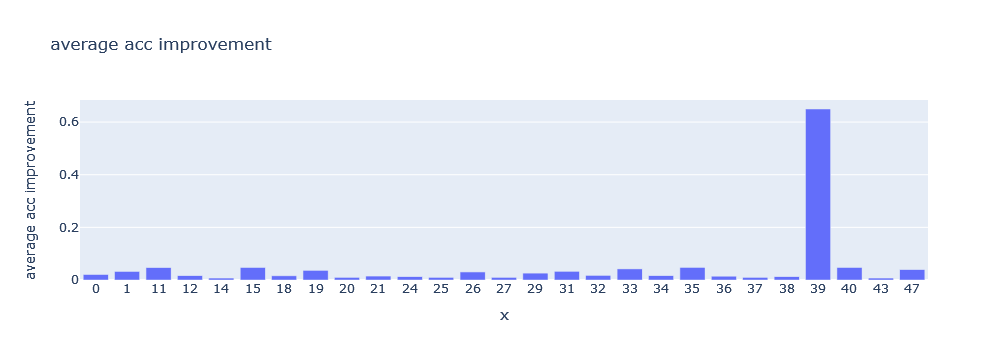

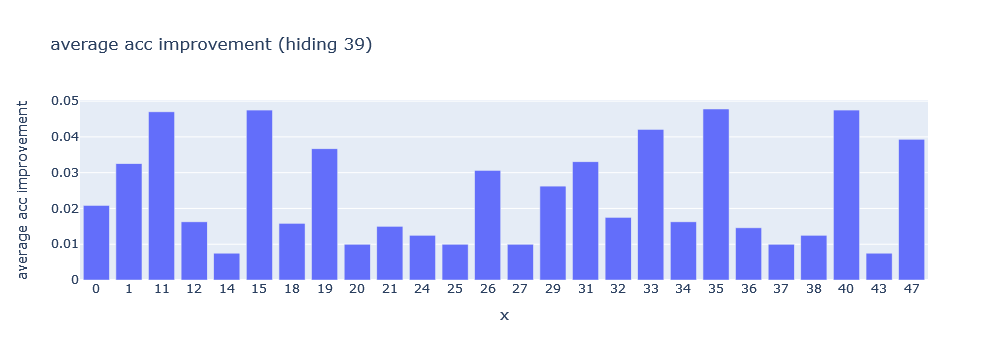

0 3
1 1
11 5
12 2
14 1
15 20
18 3
19 12
20 1
21 3
24 4
25 1
26 12
27 4
29 2
31 14
32 4
33 6
34 2
35 17
36 6
37 1
38 2
39 20
40 11
43 1
47 15


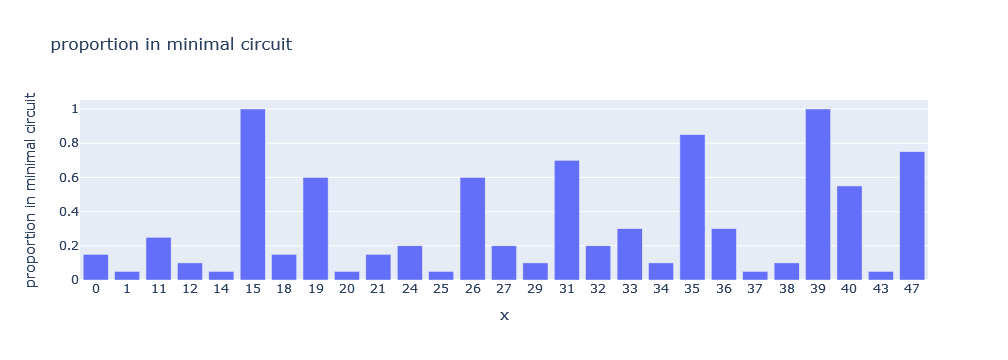

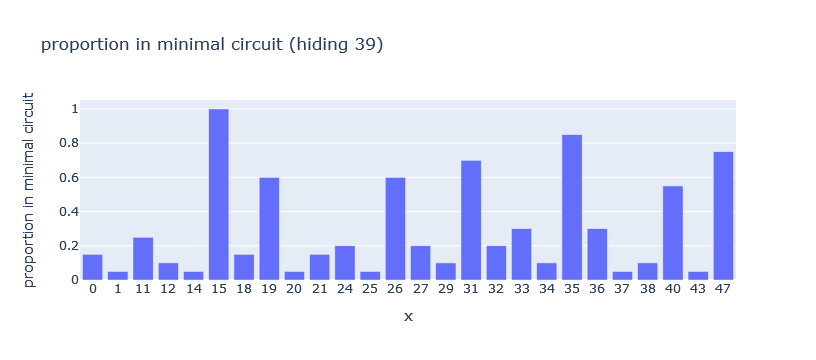

'\nwith open("layer patching log.txt", "w") as f:\n    for template_i, values in data.items():\n        f.write("template:" + templates[template_i] + "\n")\n        for patching_i, scores in values:\n            f.write("  patching:" + "\n")\n            for line in patching_formats[patching_i].split("\n"):\n                f.write("    " + line + "\n")\n            f.write(f"  {scores}" + "\n")\n'

In [40]:
import pickle
with open("itemsb.ayy", "rb") as f:
    data = pickle.load(f)

patching_formats = list(get_all_single_name_abc_patching_formats())
templates = ABC_TEMPLATES

layer_improvements = defaultdict(lambda: 0)
layer_counts = defaultdict(lambda: 0)

total = 0
for template_i, values in data.items():
    for patching_i, scores in values:
        prev_score = 0.0
        total += 1
        for score, layer in scores:
            improvement = score - prev_score
            prev_score = score
            layer_improvements[layer] += improvement
            layer_counts[layer] += 1

for layer, count in list(layer_counts.items()):
    layer_improvements[layer] = layer_improvements[layer] / float(count)

def bar_chart(data, x_labels, y_label, title, font_size=None):
    import pandas as pd
    import plotly.express as px
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()


layer_improvements = list(layer_improvements.items())
layer_improvements.sort(key=lambda x: x[0])
for k,v in layer_improvements:
    print(k,v)

bar_chart(torch.tensor([x[1] for x in layer_improvements]), x_labels=[str(x[0]) for x in layer_improvements], y_label='average acc improvement', title='average acc improvement')
bar_chart(torch.tensor([x[1] for x in layer_improvements if not x[0] == 39]), x_labels=[str(x[0]) for x in layer_improvements if not x[0] == 39], y_label='average acc improvement', title='average acc improvement (hiding 39)')

layer_counts = list(layer_counts.items())
layer_counts.sort(key=lambda x: x[0])
for k,v in layer_counts:
    print(k,v)

bar_chart(torch.tensor([x[1]/float(total) for x in layer_counts]), x_labels=[str(x[0]) for x in layer_counts], y_label='proportion in minimal circuit', title='proportion in minimal circuit')
bar_chart(torch.tensor([x[1]/float(total) for x in layer_counts if not x[0] == 39]), x_labels=[str(x[0]) for x in layer_counts if not x[0] == 39], y_label='proportion in minimal circuit', title='proportion in minimal circuit (hiding 39)')

'''
with open("layer patching log.txt", "w") as f:
    for template_i, values in data.items():
        f.write("template:" + templates[template_i] + "\n")
        for patching_i, scores in values:
            f.write("  patching:" + "\n")
            for line in patching_formats[patching_i].split("\n"):
                f.write("    " + line + "\n")
            f.write(f"  {scores}" + "\n")
'''

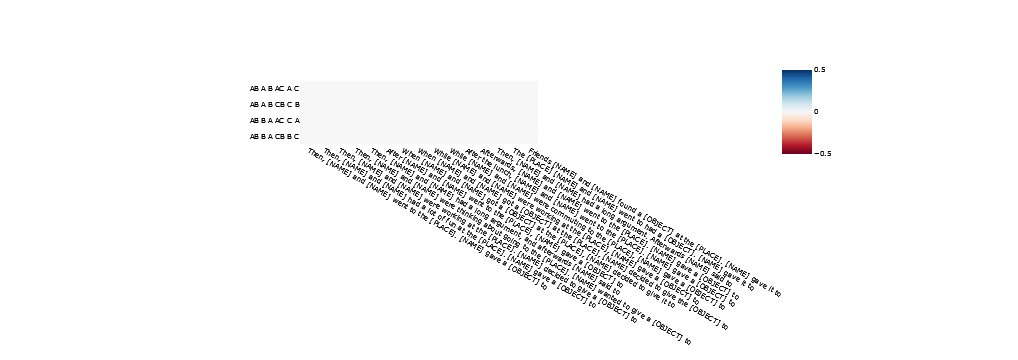

In [106]:
import plotly.express as px
import transformer_lens.utils as utils

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    if show:
        fig.show(renderer)
    else:
        return fig

imshow(scores[:len(BABA_TEMPLATES)].T, x=BABA_TEMPLATES, y=patching_formats, font_size=7, color_continuous_midpoint=None)

In [107]:
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from einops import rearrange
global storage
storage = {}

def in_proj_stofrage_hook(
    in_proj: Float[torch.Tensor, "B L E"],
    hook: HookPoint
) -> Float[torch.Tensor, "B L E"]:
    global storage
    storage["in_proj"] = in_proj

def ignore_conv_crfoss_talk_hook(
    x_conv: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:    
    D_CONV = model.cfg.d_conv
    global storage
    conv_input = storage["in_proj"]
    B, L, E = conv_input.size()
    conv_input = rearrange(conv_input, 'B L E -> B E L')
    
    ### This is identical to what the conv is doing
    # pad zeros in front
    # [B,E,D_CONV-1+L]
    padded_input = torch.nn.functional.pad(conv_input, (D_CONV-1,0), mode='constant', value=0)
    output = torch.zeros([B,E,L], device=model.cfg.device)
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    for i in range(D_CONV):
        #                 [E]                    [B,E,L]
        #output += conv_weight[:,0,i].view(E,1)*padded_input[:,:,i:i+L] # this is what conv is doing
        output += conv_weight[:,0,i].view(E,1)*conv_input
        #if i == D_CONV-1:
        #    output += conv_weight[:,0,i].view(E,1)*conv_input
    
    output += conv_bias.view(E, 1)
    
    output = rearrange(output, 'B E L -> B L E')
    return output


def ssm_input_stofrage_hook(
    ssm_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint
) -> Float[torch.Tensor, "B L E"]:
    global storage
    storage["ssm_input"] = ssm_input
    return ssm_input

global storage
def B_bar_storfage_hook(
    B_bar: Float[torch.Tensor, "B L E N"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B L E N"]:
    global storage
    storage['B_bar'] = B_bar
    return B_bar

def h_no_token_crofss_talk_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
) -> Float[torch.Tensor, "B E N"]:
    B,E,N = h.size()
    # [B E N]
    global storage
    B_bar = storage['B_bar'][:,position,:,:]
    # [B E 1]
    x = storage['ssm_input'][:,position].view(B,E,1)
    my_contribution = B_bar*x
    #corrupted_
    return B_bar*x

# doesn't work, 0.2 accuracy
def skip_ssm_hfook(
    y: Float[torch.Tensor, "B L E"],
    hook: HookPoint
) -> Float[torch.Tensor, "B L E"]:
    global ssm_input_storage
    return ssm_input_storage["ssm_input"]

# 80%
def patch_ssm_hofok(
    y: Float[torch.Tensor, "B L E"],
    hook: HookPoint
) -> Float[torch.Tensor, "B L E"]:
    y[0::2] = y[1::2]
    return y

# 85%
def patch_h_hofok(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
) -> Float[torch.Tensor, "B E N"]:
    corrupted = h[1::2]
    h[0::2] = corrupted
    return h

class EmptyObject(object):
    pass

ssm_inputs_storage = EmptyObject()


def ssm_infput_hook(
    ssm_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    ssm_inputs_storage.ssm_input = ssm_input
    return ssm_input

def C_hofok(
    C: Float[torch.Tensor, "B L N"],
    hook: HookPoint
) -> Float[torch.Tensor, "B L N"]:
    ssm_inputs_storage.C = C
    return C

def B_bar_hofok(
    B_bar: Float[torch.Tensor, "B L E N"],
    hook: HookPoint
) -> Float[torch.Tensor, "B L E N"]:
    ssm_inputs_storage.B_bar = B_bar
    return B_bar

def ssm_outpuft_hook(
    ssm_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    # return ssm_output
    # [B,L,E]
    x = ssm_inputs_storage.ssm_input
    B,L,E = x.size()
    # [B,L,N]
    C = ssm_inputs_storage.C
    B,L,N = C.size()
    # [B,L,E,N]
    B_bar = ssm_inputs_storage.B_bar
    output = torch.zeros((B,L,E), device=model.cfg.device)
    for n in range(N):
        #  [B,L,E]             [B,L,E]        [B,L,E]
        h_contributions =   B_bar[:,:,:,n]   *   x
        #[B,L,E]    [B,L,E]               [B,L,1]
        output   +=  h_contributions *  C[:,:,n].view(B,L,1)
        
    #     [B,L,E]         [B,L,E]           [E]
    return   output     +   x    *  model.blocks[layer].W_D

def patch_layer_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B E N"]:
    # patch in corrupted (they come in pairs)
    for i in range(0, h.size()[0], 2):
        h[i] = h[i+1]
    return h

def hooks_to_remove_token_cross_talk(layers):
    # remove conv cross talk
    hooks = []
    
    for layer in layers:
        L = data.data.size()[1]
        hooks.append((f"blocks.{layer}.hook_conv", patch_layer_hook))
        for l in range(L):
            hooks.append((f"blocks.{layer}.hook_h.{l}", patch_layer_hook))
    '''
    for layer in layers:
        #hooks.append((f"blocks.{layer}.hook_in_proj", in_proj_storage_hook))
        #hooks.append((f"blocks.{layer}.hook_conv", partial(ignore_conv_cross_talk_hook, layer=layer)))
        #hooks.append((f"blocks.{layer}.hook_conv", patch_ssm_hook))
        #hooks.append((f"blocks.{layer}.hook_ssm_input", ssm_input_storage_hook))
        #hooks.append((f"blocks.{layer}.hook_B_bar", B_bar_storage_hook))
        #hooks.append((f"blocks.{layer}.hook_ssm_input", partial(ssm_input_hook, layer=layer)))
        #hooks.append((f"blocks.{layer}.hook_C", C_hook))
        #hooks.append((f"blocks.{layer}.hook_B_bar", B_bar_hook))
        #hooks.append((f"blocks.{layer}.hook_ssm_output", partial(ssm_output_hook, layer=layer)))
        

        
        #L = data.data.size()[1]
        for l in range(L):
            #hooks.append((f"blocks.{layer}.hook_h.{l}", partial(h_no_token_cross_talk_hook, position=l)))
            #hooks.append((f"blocks.{layer}.hook_h.{l}", partial(patch_h_hook, position=l)))
            hooks.append((f"blocks.{layer}.hook_h.{l}", partial(patch_h_hook, position=l)))
        #hooks.append((f"blocks.{layer}.hook_ssm_input", patch_h_hook))
    '''
    return hooks


In [11]:
from acdc.data.ioi import good_names
from collections import defaultdict
name_tokens = set([model.to_single_token(" " + name) for name in good_names])\

print(name_tokens)
print(data.data.size())
name_positions = defaultdict(lambda: [])
for i in range(data.data.size()[0]):
    prompt_tokens = data.data[i]
    name_pos = 0
    for i, tok in enumerate(prompt_tokens):
        if tok.item() in name_tokens:
            name_positions[name_pos].append(i) # +1 because conv
            name_pos += 1
    if name_pos != 5: raise ValueError(f"data point {model.to_str_tokens(data)} does not have 5 names")

{50178, 46600, 31755, 46604, 11276, 33811, 46612, 16916, 18966, 12824, 32794, 7195, 33821, 33313, 37921, 29222, 31270, 28200, 18985, 37930, 28712, 7727, 24112, 32817, 36400, 5171, 44085, 35382, 30274, 20554, 15435, 33357, 49231, 38994, 21587, 7252, 40537, 27738, 44123, 44124, 14943, 45664, 15458, 49765, 19046, 35944, 29804, 23662, 37497, 22138, 27773, 28798, 33407, 27264, 9857, 35972, 6277, 14468, 4744, 32393, 32905, 22671, 20628, 17560, 32920, 21661, 16543, 31903, 16553, 18089, 41131, 28331, 20145, 46262, 30397, 41151, 22723, 23239, 17100, 37073, 22739, 49365, 16598, 47831, 31959, 22234, 23259, 20189, 45790, 29927, 46312, 46831, 29936, 31472, 26355, 6393, 8444, 26876, 26878, 6911, 25856, 19717, 8966, 38150, 26888, 27917, 6416, 39184, 24336, 48401, 23316, 37144, 31513, 42266, 29989, 27434, 45867, 36139, 29489, 27955, 27443, 22838, 7993, 13114, 13629, 28991, 40771, 25413, 44870, 18247, 47944, 26953, 35657, 13651, 27991, 26456, 48990, 34655, 16225, 28518, 20839, 43367, 10092, 11116, 3108

In [12]:
import torch
from tqdm.notebook import tqdm

LAYER = 39
batch_size = 40

hook = f"blocks.{LAYER}.hook_ssm_input"

name_averages = defaultdict(lambda: {})
name_choices = defaultdict(lambda: defaultdict(lambda: []))
counts = defaultdict(lambda: {})

TOTAL_AVG_NAME = "total"

for tok in name_tokens:
    for name_i in range(len(name_positions)):
        name_averages[name_i][tok] = torch.zeros([model.cfg.E], device=model.cfg.device)
        counts[name_i][tok] = 0

for batch_start in tqdm(list(range(0, data.data.size()[0], batch_size))):
    batch_end = min(data.data.size()[0], batch_start+batch_size)
    data_batch = data.data[batch_start:batch_end]
    logits, activations = model.run_with_cache(data_batch, names_filter=[hook], fast_ssm=True, fast_conv=True)
    for name_i in range(len(name_positions)):
        positions = torch.tensor(name_positions[name_i][batch_start:batch_end], device=model.cfg.device)
        batch_name_tokens = data_batch[torch.arange(batch_end-batch_start),positions]
        ssm_inputs = activations[hook]
        for batch_i, name_tok in enumerate(batch_name_tokens):
            #print(ssm_inputs[batch_i, position].size())
            try:
                position = positions[batch_i]+1
                name_averages[name_i][name_tok.item()] += ssm_inputs[batch_i, position]
                if len(name_choices[name_i][name_tok.item()]) < 20: # save some memory
                    name_choices[name_i][name_tok.item()].append(ssm_inputs[batch_i, position])
                #name_averages['all'][name_tok.item()] += ssm_inputs[batch_i, position]
                #name_averages[name_i][TOTAL_AVG_NAME] += ssm_inputs[batch_i, position]
                counts[name_i][name_tok.item()] += 1
                #counts[name_i][TOTAL_AVG_NAME] += 1
            except:
                print(model.to_str_tokens([name_tok]))
                raise
    
print(counts)
for name_i in range(len(name_positions)):
    for name_tok in list(name_averages[name_i].keys()):
        name_averages[name_i][name_tok] = name_averages[name_i][name_tok] / counts[name_i][name_tok]


  0%|          | 0/1000 [00:00<?, ?it/s]

defaultdict(<function <lambda> at 0x7f8005106950>, {0: {50178: 196, 46600: 204, 31755: 178, 46604: 178, 11276: 162, 33811: 200, 46612: 190, 16916: 190, 18966: 164, 12824: 200, 32794: 212, 7195: 238, 33821: 192, 33313: 200, 37921: 178, 29222: 208, 31270: 202, 28200: 168, 18985: 180, 37930: 240, 28712: 196, 7727: 222, 24112: 218, 32817: 170, 36400: 182, 5171: 172, 44085: 222, 35382: 204, 30274: 172, 20554: 160, 15435: 168, 33357: 216, 49231: 190, 38994: 150, 21587: 232, 7252: 200, 40537: 194, 27738: 224, 44123: 238, 44124: 236, 14943: 148, 45664: 200, 15458: 206, 49765: 198, 19046: 154, 35944: 156, 29804: 186, 23662: 206, 37497: 200, 22138: 242, 27773: 188, 28798: 150, 33407: 186, 27264: 218, 9857: 234, 35972: 230, 6277: 226, 14468: 222, 4744: 166, 32393: 190, 32905: 224, 22671: 170, 20628: 178, 17560: 214, 32920: 348, 21661: 188, 16543: 206, 31903: 184, 16553: 182, 18089: 198, 41131: 230, 28331: 174, 20145: 222, 46262: 188, 30397: 178, 41151: 208, 22723: 182, 23239: 190, 17100: 212, 370

In [52]:
random.seed(27)
for name_i in range(len(name_positions)):
    for name_tok in list(name_averages[name_i].keys()):
        print()
        print(name_i, name_tok, torch.linalg.norm(name_averages[name_i][name_tok], ord=2))
        print(len(name_choices[name_i][name_tok]))
        print(counts[name_i][name_tok])
        print(name_i, name_tok, torch.linalg.norm(random.choice(name_choices[name_i][name_tok]), ord=2))
        print(name_i, name_tok, torch.linalg.norm(random.choice(name_choices[name_i][name_tok]), ord=2))


0 50178 tensor(12.7626, device='cuda:0')
20
166
0 50178 tensor(12.3633, device='cuda:0')
0 50178 tensor(13.0378, device='cuda:0')

0 46600 tensor(12.8618, device='cuda:0')
20
186
0 46600 tensor(13.1206, device='cuda:0')
0 46600 tensor(13.1206, device='cuda:0')

0 31755 tensor(13.4229, device='cuda:0')
20
180
0 31755 tensor(14.2686, device='cuda:0')
0 31755 tensor(14.2686, device='cuda:0')

0 46604 tensor(12.4573, device='cuda:0')
20
212
0 46604 tensor(13.8661, device='cuda:0')
0 46604 tensor(12.3146, device='cuda:0')

0 10765 tensor(12.8339, device='cuda:0')
20
194
0 10765 tensor(13.7052, device='cuda:0')
0 10765 tensor(13.4607, device='cuda:0')

0 11276 tensor(13.3126, device='cuda:0')
20
236
0 11276 tensor(14.2519, device='cuda:0')
0 11276 tensor(14.2519, device='cuda:0')

0 33811 tensor(13.4167, device='cuda:0')
20
180
0 33811 tensor(14.3506, device='cuda:0')
0 33811 tensor(14.3506, device='cuda:0')

0 46612 tensor(13.5347, device='cuda:0')
20
224
0 46612 tensor(14.7716, device='cu

In [61]:
import random
random.seed(27)

DO_DIFF = False

model_kwargs = {"fast_ssm": True, "fast_conv": True}

original_corrects = {}
original_replaces = {}
replace_corrects = {}
replace_replaces = {}
patched_corrects = {}
patched_replaces = {}

for position_1 in range(5):
    for position_2 in range(5):
        print(position_1, position_2)
        original_correct = []
        original_replace = []
        replace_correct = []
        replace_replace = []
        patched_correct = []
        patched_replace = []

        original_corrects[(position_1, position_2)] = original_correct
        original_replaces[(position_1, position_2)] = original_replace
        replace_corrects[(position_1, position_2)] = replace_correct
        replace_replaces[(position_1, position_2)] = replace_replace
        patched_corrects[(position_1, position_2)] = patched_correct
        patched_replaces[(position_1, position_2)] = patched_replace

        batched_inputs = []
        batched_corrupted_inputs = []
        num_found = 0
        hooks = []
        corrupted_hooks = []
        last_token_positions = []
        replace_toks = []
        answer_toks = []
        batch_i = 0
        while True:
            data_i = random.choice(list(range(data.data.size()[0])))
            
            import random
            from functools import partial
        
            data_i = (data_i // 2)*2
            patched_i = data_i + 1
            
            data_tokens = data.data[data_i]
            corrupted_tokens = data.data[patched_i]
            answer_tok = data.correct[data_i][0].item()
            answer = model.to_str_tokens(torch.tensor([answer_tok]))[0]
            replace_tok = data.correct[patched_i][0].item()
            new_answer_tok = replace_tok
            if position_1 > 2:
                # replacing patched name for 3 and 4 wouldn't change the output
                # instead, we need to substitute the answer
                # this results in a different answer being outputted (the name that isn't present)
                replace_tok = answer_tok
                # find the new answer, which is the name at the position we are overwriting
                token_position_of_new_answer = name_positions[position_1][data_i]
                new_answer_tok = data.data[data_i][token_position_of_new_answer].item()
                
                        
            replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
            
            
            '''
            others = model.to_str_tokens(data.incorrect[data_i])
            print("prompt", model.to_str_tokens(data_tokens))
            print("answer", answer)
            print("other names", others)
            replace_name = model.to_str_tokens(answer)[0]
            while True:
                replace_tok = random.choice(list(name_tokens))
                replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
                if not replace_name in [answer] + others:
                    break
            '''
            #print("got replace name", repr(replace_name))
            #print("logits before replace")
            last_token_pos = data.last_token_position[data_i]
            def replace_hook(
                x,
                hook,
                position,
                replace_vec,
                replace_add_vec,
                batch_i,
            ):
                if not replace_vec is None:
                    x[batch_i, position] = replace_vec
                if not replace_add_vec is None:
                    x[batch_i, position] += replace_add_vec
                return x
            
            answer_positions = []
            if position_1 < 3:
                for name_i in range(len(name_positions)):
                    position = name_positions[name_i][data_i]
                    if data_tokens[position].item() == answer_tok:
                        answer_positions.append((name_i, position))
            else:
                answer_positions.append((position_1, name_positions[position_1][data_i]))
            #print("answer positions", answer_positions)
            bad = False
            for name_i, position in answer_positions:
                # throw out data points that don't have the answer at the desired position
                # this ensures that we patch the token corresponding to the answer
                # (only relevant for names 0-2, for names 3-4 we substitute the answer always)
                if (position_1 <= 2 and not name_i == position_1) or len(answer_positions) > 2:
                    bad = True
                    break
                
                #replace_vec = random.choice(name_choices[name_i][replace_tok])
                replace_vec = name_averages[position_2][replace_tok]
                # two ways to do it
                # diff(name) = avg - name
                # if we add this it should "erase" name
                # if we subtract this it should "add" name
                # so we can do
                # replace_add_vec = diff(answer) - diff(replace)
                #diff_answer = name_averages[name_i][TOTAL_AVG_NAME] - name_averages[name_i][answer_tok]
                #diff_replace = name_averages[name_i][TOTAL_AVG_NAME] - name_averages[name_i][replace_tok]
                #replace_add_vec = diff_answer - diff_replace
                # this is (avg-a) - (avg-r) = r-a
                # in other words the average doesn't matter for this
                # and it's just subtract avg for a and add average for b
                if position_1 <= 2:
                    replace_add_vec = name_averages[position_2][replace_tok] - name_averages[position_2][answer_tok]
                else:
                    # we need to subtract the name that was here (now the new answer) and add the replace_tok 
                    replace_add_vec = name_averages[position_2][replace_tok] - name_averages[position_2][new_answer_tok]
                # then we do
                # replace_vec
                # we have x
                # we want y
                # we can do
                # x-y
                # and apply it to y
                #replace_diff = name_averages[name_i][TOTAL_AVG_NAME]
        
                if DO_DIFF:
                    hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=None, replace_add_vec=replace_add_vec, batch_i=batch_i)))
                else:
                    hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=replace_vec, replace_add_vec=None, batch_i=batch_i)))
            if bad:
                continue
            else:
                num_found += 1
            
            #logits = model(data_tokens.view(1,-1), **model_kwargs)
            #print(f"answer {repr(answer)} logit {logits[0,last_token_pos,answer_tok]}")
            #print(f"replace {repr(replace_name)} logit {logits[0,last_token_pos,replace_tok]}")
            #original_correct.append(logits[0,last_token_pos,answer_tok].item())
            #original_replace.append(logits[0,last_token_pos,replace_tok].item())
            if num_found % 10 == 0:
                print(num_found)
            batched_inputs.append(data_tokens.view(1, -1))
            #logits_modified = model.run_with_hooks(data_tokens.view(1, -1), fwd_hooks=hooks, **model_kwargs)
            #print(logits_modified.size())
            #print(f"modified answer {repr(answer)} logit {logits_modified[0,last_token_pos,answer_tok]}")
            #print(f"modified replace {repr(replace_name)} logit {logits_modified[0,last_token_pos,replace_tok]}")
            batched_corrupted_inputs.append(corrupted_tokens.view(1, -1))
            for name_i, position in answer_positions:
                replace_vec = name_averages[position_2][answer_tok]
                replace_add_vec = name_averages[position_2][answer_tok] - name_averages[position_2][replace_tok]            
                if DO_DIFF:
                    corrupted_hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=None, replace_add_vec=replace_add_vec, batch_i=batch_i)))
                else:
                    corrupted_hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=replace_vec, replace_add_vec=None, batch_i=batch_i)))
            last_token_positions.append(last_token_pos)
            replace_toks.append(new_answer_tok)
            answer_toks.append(answer_tok)

            
            batch_i += 1
            
            
            #logits_patched, acts = model.run_with_cache(data.data[patched_i].view(1,-1), names_filter=[hook])
            #print(f"patched answer {repr(answer)} logit {logits_patched[0,last_token_pos,answer_tok]}")
            #print(f"patched replace {repr(replace_name)} logit {logits_patched[0,last_token_pos,replace_tok]}")
            #patched_correct.append(logits_patched[0,last_token_pos,answer_tok].item())
            #patched_replace.append(logits_patched[0,last_token_pos,replace_tok].item())
            if num_found > 100:
                break

        batched_inputs = torch.cat(batched_inputs, dim=0)
        batched_corrupted_inputs = torch.cat(batched_corrupted_inputs, dim=0)
        
        logits_modified = model.run_with_hooks(batched_inputs, fwd_hooks=hooks, **model_kwargs)
        #print(logits_modified.size())
        #print(f"modified answer {repr(answer)} logit {logits_modified[0,last_token_pos,answer_tok]}")
        #print(f"modified replace {repr(replace_name)} logit {logits_modified[0,last_token_pos,replace_tok]}")
        for i in range(batched_inputs.size()[0]):
            replace_correct.append(logits_modified[i,last_token_positions[i],answer_toks[i]].item())
            replace_replace.append(logits_modified[i,last_token_positions[i],replace_toks[i]].item())        
        del logits_modified
        #logits_modified_corrupted = model.run_with_hooks(batched_corrupted_inputs, fwd_hooks=corrupted_hooks, **model_kwargs)
        #for i in range(batched_inputs.size()[0]):
        #    replace_correct.append(logits_modified_corrupted[i,last_token_positions[i],replace_toks[i]].item())
        #    replace_replace.append(logits_modified_corrupted[i,last_token_positions[i],answer_toks[i]].item())
        
    


def bar_chart(data, x_labels, y_label, title, font_size=None):
    import pandas as pd
    import plotly.express as px
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()

0 0
10
20
30
40
50
60
70
80
90
100
0 1
10
20
30
40
50
60
70
80
90
100
0 2
10
20
30
40
50
60
70
80
90
100
0 3
10
20
30
40
50
60
70
80
90
100
0 4
10
20
30
40
50
60
70
80
90
100
1 0
10
20
30
40
50
60
70
80
90
100
1 1
10
20
30
40
50
60
70
80
90
100
1 2
10
20
30
40
50
60
70
80
90
100
1 3
10
20
30
40
50
60
70
80
90
100
1 4
10
20
30
40
50
60
70
80
90
100
2 0
10
20
30
40
50
60
70
80
90
100
2 1
10
20
30
40
50
60
70
80
90
100
2 2
10
20
30
40
50
60
70
80
90
100
2 3
10
20
30
40
50
60
70
80
90
100
2 4
10
20
30
40
50
60
70
80
90
100
3 0
10
20
30
40
50
60
70
80
90
100
3 1
10
20
30
40
50
60
70
80
90
100
3 2
10
20
30
40
50
60
70
80
90
100
3 3
10
20
30
40
50
60
70
80
90
100
3 4
10
20
30
40
50
60
70
80
90
100
4 0
10
20
30
40
50
60
70
80
90
100
4 1
10
20
30
40
50
60
70
80
90
100
4 2
10
20
30
40
50
60
70
80
90
100
4 3
10
20
30
40
50
60
70
80
90
100
4 4
10
20
30
40
50
60
70
80
90
100


In [64]:

n_correct_matrix = torch.zeros([5,5])

for pos1 in range(5):
    for pos2 in range(5):
        #original_diff = -torch.tensor(original_correct) + torch.tensor(original_replace)
        replace_diff = -torch.tensor(replace_corrects[(pos1,pos2)]) + torch.tensor(replace_replaces[(pos1,pos2)])
        #patched_diff = -torch.tensor(patched_correct) + torch.tensor(patched_replace)
        
        #print(f'original min diff {torch.min(original_diff)} max diff {torch.max(original_diff)} avg diff {torch.mean(original_diff)}')
        #print(f'replace min diff {torch.min(replace_diff)} max diff {torch.max(replace_diff)} avg diff {torch.mean(replace_diff)}')
        #print(f'patch min diff {torch.min(patched_diff)} max diff {torch.max(patched_diff)} avg diff {torch.mean(patched_diff)}')

        n_correct_matrix[pos1, pos2] = torch.sum(replace_diff > 0)/replace_diff.size()[0]
        #print(f'original n correct {torch.sum(original_diff < 0)} / {original_diff.size()[0]}')
        #print(f'replace n correct {torch.sum(replace_diff < 0)} / {original_diff.size()[0]}')
        #print(f'patch n correct {torch.sum(patched_diff < 0)} / {original_diff.size()[0]}')

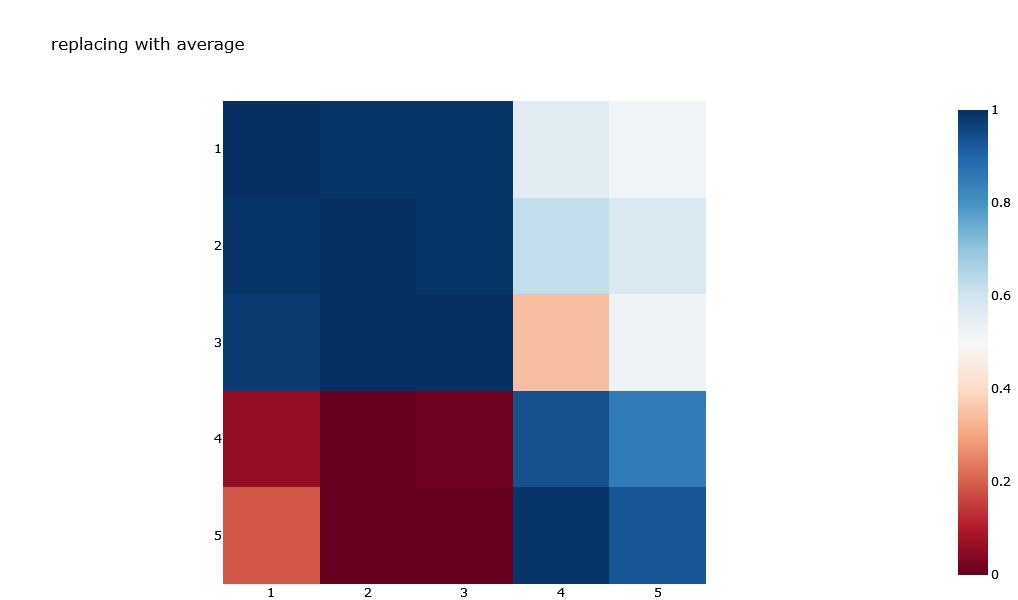

In [65]:

# modified from neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
            x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig

imshow(n_correct_matrix, color_continuous_midpoint=None, y=[1,2,3,4,5], x=[1,2,3,4,5], title='replacing with average', font_size=12)

In [97]:
import random
random.seed(27)

DO_DIFF = True

model_kwargs = {"fast_ssm": True, "fast_conv": True}

original_corrects = {}
original_replaces = {}
replace_corrects = {}
replace_replaces = {}
patched_corrects = {}
patched_replaces = {}
import itertools
name_toks = sorted(list(name_tokens))[:70]
print(len(name_toks))
for forbidden_name in ['Summer']:
    name_tok = model.to_tokens(' ' + forbidden_name)[0][1].item()
    name_toks = [t for t in name_toks if not t == name_tok]
    print(len(name_toks))

name_toks_strs = [model.to_str_tokens(torch.tensor([t]))[0] for t in name_toks]
print(name_toks_strs)

for position_1, name_tok_1, name_tok_2 in tqdm(list(itertools.product(*[range(1), name_toks, name_toks]))):
        original_correct = []
        original_replace = []
        replace_correct = []
        replace_replace = []
        patched_correct = []
        patched_replace = []
         
        key = (position_1, name_tok_1, name_tok_2)
        original_corrects[key] = original_correct
        original_replaces[key] = original_replace
        replace_corrects[key] = replace_correct
        replace_replaces[key] = replace_replace
        patched_corrects[key] = patched_correct
        patched_replaces[key] = patched_replace


        batched_inputs = []
        batched_corrupted_inputs = []
        num_found = 0
        hooks = []
        corrupted_hooks = []
        last_token_positions = []
        replace_toks = []
        answer_toks = []
        batch_i = 0
        while True:
            data_i = random.choice(list(range(data.data.size()[0])))
            
            import random
            from functools import partial
        
            data_i = (data_i // 2)*2
            patched_i = data_i + 1
            
            data_tokens = data.data[data_i].clone()
            corrupted_tokens = data.data[patched_i].clone()
            answer_tok = data.correct[data_i][0].item()
            answer = model.to_str_tokens(torch.tensor([answer_tok]))[0]
            replace_tok = data.correct[patched_i][0].item()
            replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
            
            all_names = set([x.item() for x in data.incorrect[data_i]]) | set([answer_tok]) | set([replace_tok])
            if name_tok_1 in all_names or name_tok_2 in all_names:
                continue

        
            
            '''
            others = model.to_str_tokens(data.incorrect[data_i])
            print("prompt", model.to_str_tokens(data_tokens))
            print("answer", answer)
            print("other names", others)
            replace_name = model.to_str_tokens(answer)[0]
            while True:
                replace_tok = random.choice(list(name_tokens))
                replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
                if not replace_name in [answer] + others:
                    break
            '''
            #print("got replace name", repr(replace_name))
            #print("logits before replace")
            last_token_pos = data.last_token_position[data_i]
            def replace_hook(
                x,
                hook,
                position,
                replace_vec,
                replace_add_vec,
                batch_i,
            ):
                if not replace_vec is None:
                    x[batch_i, position] = replace_vec
                if not replace_add_vec is None:
                    x[batch_i, position] += replace_add_vec
                return x
            
            answer_positions = []
            for name_i in range(len(name_positions)):
                position = name_positions[name_i][data_i]
                if data_tokens[position].item() == answer_tok:
                    data_tokens[position] = name_tok_1
                    corrupted_tokens[position] = name_tok_2
                    answer_positions.append((name_i, position))

            answer_tok = name_tok_1
            replace_tok = name_tok_2
            #print("answer positions", answer_positions)
            bad = False
            for name_i, position in answer_positions:
                if not name_i == position_1 or len(answer_positions) > 2:
                    bad = True
                    break
                
                name_i = position_1
                replace_vec = random.choice(name_choices[name_i][replace_tok])
                # two ways to do it
                # diff(name) = avg - name
                # if we add this it should "erase" name
                # if we subtract this it should "add" name
                # so we can do
                # replace_add_vec = diff(answer) - diff(replace)
                #diff_answer = name_averages[name_i][TOTAL_AVG_NAME] - name_averages[name_i][answer_tok]
                #diff_replace = name_averages[name_i][TOTAL_AVG_NAME] - name_averages[name_i][replace_tok]
                #replace_add_vec = diff_answer - diff_replace
                # this is (avg-a) - (avg-r) = r-a
                # in other words the average doesn't matter for this
                # and it's just subtract avg for a and add average for b
                replace_add_vec = name_averages[name_i][replace_tok] - name_averages[name_i][answer_tok]
                # then we do
                # replace_vec
                # we have x
                # we want y
                # we can do
                # x-y
                # and apply it to y
                #replace_diff = name_averages[name_i][TOTAL_AVG_NAME]
        
                if DO_DIFF:
                    hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=None, replace_add_vec=replace_add_vec, batch_i=batch_i)))
                else:
                    hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=replace_vec, replace_add_vec=None, batch_i=batch_i)))
            if bad:
                continue
            else:
                num_found += 1
            
            #logits = model(data_tokens.view(1,-1), **model_kwargs)
            #print(f"answer {repr(answer)} logit {logits[0,last_token_pos,answer_tok]}")
            #print(f"replace {repr(replace_name)} logit {logits[0,last_token_pos,replace_tok]}")
            #original_correct.append(logits[0,last_token_pos,answer_tok].item())
            #original_replace.append(logits[0,last_token_pos,replace_tok].item())

            batched_inputs.append(data_tokens.view(1, -1))
            #logits_modified = model.run_with_hooks(data_tokens.view(1, -1), fwd_hooks=hooks, **model_kwargs)
            #print(logits_modified.size())
            #print(f"modified answer {repr(answer)} logit {logits_modified[0,last_token_pos,answer_tok]}")
            #print(f"modified replace {repr(replace_name)} logit {logits_modified[0,last_token_pos,replace_tok]}")
            '''
            batched_corrupted_inputs.append(corrupted_tokens.view(1, -1))
            for name_i, position in answer_positions:
                name_i = position_2
                replace_vec = name_averages[name_i][answer_tok]
                replace_add_vec = name_averages[name_i][answer_tok] - name_averages[name_i][replace_tok]            
                if DO_DIFF:
                    corrupted_hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=None, replace_add_vec=replace_add_vec, batch_i=batch_i)))
                else:
                    corrupted_hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=replace_vec, replace_add_vec=None, batch_i=batch_i)))
            '''
            last_token_positions.append(last_token_pos)
            replace_toks.append(replace_tok)
            answer_toks.append(answer_tok)

            
            batch_i += 1
            
            
            #logits_patched, acts = model.run_with_cache(data.data[patched_i].view(1,-1), names_filter=[hook])
            #print(f"patched answer {repr(answer)} logit {logits_patched[0,last_token_pos,answer_tok]}")
            #print(f"patched replace {repr(replace_name)} logit {logits_patched[0,last_token_pos,replace_tok]}")
            #patched_correct.append(logits_patched[0,last_token_pos,answer_tok].item())
            #patched_replace.append(logits_patched[0,last_token_pos,replace_tok].item())
            if num_found > 10:
                break

        batched_inputs = torch.cat(batched_inputs, dim=0)
        #batched_corrupted_inputs = torch.cat(batched_corrupted_inputs, dim=0)
        
        logits_modified = model.run_with_hooks(batched_inputs, fwd_hooks=hooks, **model_kwargs)
        #print(logits_modified.size())
        #print(f"modified answer {repr(answer)} logit {logits_modified[0,last_token_pos,answer_tok]}")
        #print(f"modified replace {repr(replace_name)} logit {logits_modified[0,last_token_pos,replace_tok]}")
        for i in range(batched_inputs.size()[0]):
            replace_correct.append(logits_modified[i,last_token_positions[i],answer_toks[i]].item())
            replace_replace.append(logits_modified[i,last_token_positions[i],replace_toks[i]].item())        
        del logits_modified
        #logits_modified_corrupted = model.run_with_hooks(batched_corrupted_inputs, fwd_hooks=corrupted_hooks, **model_kwargs)
        #for i in range(batched_inputs.size()[0]):
        #    replace_correct.append(logits_modified_corrupted[i,last_token_positions[i],replace_toks[i]].item())
        #    replace_replace.append(logits_modified_corrupted[i,last_token_positions[i],answer_toks[i]].item())
        
    


def bar_chart(data, x_labels, y_label, title, font_size=None):
    import pandas as pd
    import plotly.express as px
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()

70
69
[' John', ' Mark', ' David', ' Paul', ' James', ' George', ' Michael', ' Mary', ' Christian', ' Robert', ' Thomas', ' William', ' Jesus', ' Richard', ' Peter', ' Charles', ' Martin', ' Henry', ' Jackson', ' Joseph', ' Daniel', ' Francisco', ' Andrew', ' Taylor', ' Stephen', ' Eric', ' Elizabeth', ' Edward', ' Ryan', ' Adam', ' Jordan', ' Grant', ' Alexander', ' Brian', ' Jacob', ' Diego', ' Kelly', ' Kevin', ' Patrick', ' Sarah', ' Cooper', ' Victoria', ' Morgan', ' Anthony', ' Anna', ' Jason', ' Kennedy', ' Cole', ' Carter', ' Austin', ' Maria', ' Sydney', ' Alan', ' Antonio', ' Luke', ' Matthew', ' Grace', ' Jonathan', ' Benjamin', ' Steven', ' Christopher', ' Parker', ' Margaret', ' Hunter', ' Kate', ' Oliver', ' Samuel', ' Justin', ' Brooklyn']


  0%|          | 0/4761 [00:00<?, ?it/s]

In [98]:

n_correct_matrix = torch.zeros([len(name_toks),len(name_toks)])

for position_1, name_tok_1, name_tok_2 in list(itertools.product(*[range(1), name_toks, name_toks])):
        
        key = (position_1, name_tok_1, name_tok_2)
        pos1 = name_toks.index(name_tok_1)
        pos2 = name_toks.index(name_tok_2)
        #original_diff = -torch.tensor(original_correct) + torch.tensor(original_replace)
        replace_diff = -torch.tensor(replace_corrects[key]) + torch.tensor(replace_replaces[key])
        #patched_diff = -torch.tensor(patched_correct) + torch.tensor(patched_replace)
        
        #print(f'original min diff {torch.min(original_diff)} max diff {torch.max(original_diff)} avg diff {torch.mean(original_diff)}')
        #print(f'replace min diff {torch.min(replace_diff)} max diff {torch.max(replace_diff)} avg diff {torch.mean(replace_diff)}')
        #print(f'patch min diff {torch.min(patched_diff)} max diff {torch.max(patched_diff)} avg diff {torch.mean(patched_diff)}')

        n_correct_matrix[pos1, pos2] = torch.sum(replace_diff > 0)/replace_diff.size()[0]
        if pos1 == pos2:
            n_correct_matrix[pos1, pos2] = 1.0 # ez
        #print(f'original n correct {torch.sum(original_diff < 0)} / {original_diff.size()[0]}')
        #print(f'replace n correct {torch.sum(replace_diff < 0)} / {original_diff.size()[0]}')
        #print(f'patch n correct {torch.sum(patched_diff < 0)} / {original_diff.size()[0]}')

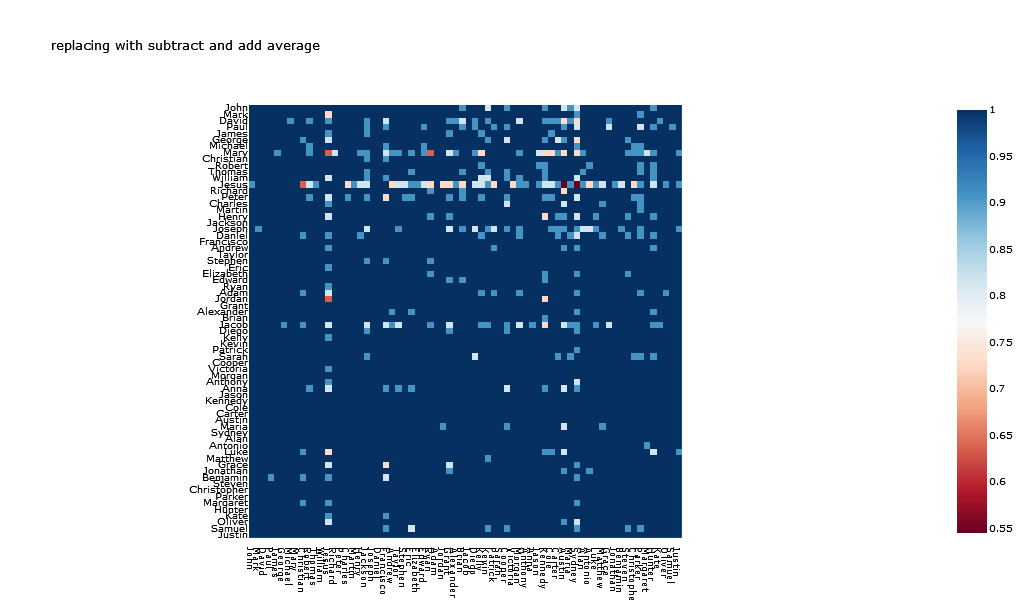

In [101]:


def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig

imshow(n_correct_matrix[:-1,:-1], color_continuous_midpoint=None, y=name_toks_strs[:-1], x=name_toks_strs[:-1], title='replacing with subtract and add average', font_size=9)

In [21]:
import random
random.seed(27)

DO_DIFF = True

model_kwargs = {"fast_ssm": True, "fast_conv": True}

original_corrects = {}
original_replaces = {}
replace_corrects = {}
replace_replaces = {}
patched_corrects = {}
patched_replaces = {}

for position_1 in range(3):
  for name_tok_1 in list(name_tokens):
     for name_tok_2 in list(name_tokens):
        print(position_1, name_tok_1, name_tok_2)
        original_correct = []
        original_replace = []
        replace_correct = []
        replace_replace = []
        patched_correct = []
        patched_replace = []

        key = (position_1, name_tok_1, name_tok_2)
        original_corrects[key] = original_correct
        original_replaces[key] = original_replace
        replace_corrects[key] = replace_correct
        replace_replaces[key] = replace_replace
        patched_corrects[key] = patched_correct
        patched_replaces[key] = patched_replace

        batched_inputs = []
        batched_corrupted_inputs = []
        num_found = 0
        hooks = []
        corrupted_hooks = []
        last_token_positions = []
        replace_toks = []
        answer_toks = []
        while True:
            batch_i = 0
            data_i = random.choice(list(range(data.data.size()[0])))
            
            import random
            from functools import partial
        
            data_i = (data_i // 2)*2
            patched_i = data_i + 1
            
            data_tokens = data.data[data_i].clone()
            corrupted_tokens = data.data[patched_i].clone()
            answer_tok = data.correct[data_i][0].item()
            answer = model.to_str_tokens(torch.tensor([answer_tok]))[0]
            replace_tok = data.correct[patched_i][0].item()
            replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]


            all_names = set([x.item() for x in data.incorrect[data_i]]) | set([answer_tok]) | set([replace_tok])
            if name_tok_1 in all_names or name_tok_2 in all_names:
                continue

            answer_tok = name_tok_1
            replace_tok = name_tok_2
            
            
            replace_toks.append(replace_tok)
            answer_toks.append(answer_tok)
            '''
            others = model.to_str_tokens(data.incorrect[data_i])
            print("prompt", model.to_str_tokens(data_tokens))
            print("answer", answer)
            print("other names", others)
            replace_name = model.to_str_tokens(answer)[0]
            while True:
                replace_tok = random.choice(list(name_tokens))
                replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
                if not replace_name in [answer] + others:
                    break
            '''
            #print("got replace name", repr(replace_name))
            #print("logits before replace")
            last_token_pos = data.last_token_position[data_i]
            last_token_positions.append(last_token_pos)
            def replace_hook(
                x,
                hook,
                position,
                replace_vec,
                replace_add_vec,
                batch_i,
            ):
                if not replace_vec is None:
                    x[batch_i, position] = replace_vec
                if not replace_add_vec is None:
                    x[batch_i, position] += replace_add_vec
                return x
            
            answer_positions = []
            for name_i in range(len(name_positions)):
                position = name_positions[name_i][data_i]
                if data_tokens[position].item() == answer_tok:
                    answer_positions.append((name_i, position))
                    data_tokens[position] = name_tok_1
                    corrupted_tokens[position] = name_tok_2
            
            #print("answer positions", answer_positions)
            bad = False
            for name_i, position in answer_positions:
                if not name_i == position_1 or len(answer_positions) > 2:
                    bad = True
                    break

                
                
                name_i = position_2
                replace_vec = random.choice(name_choices[name_i][replace_tok])
                # two ways to do it
                # diff(name) = avg - name
                # if we add this it should "erase" name
                # if we subtract this it should "add" name
                # so we can do
                # replace_add_vec = diff(answer) - diff(replace)
                #diff_answer = name_averages[name_i][TOTAL_AVG_NAME] - name_averages[name_i][answer_tok]
                #diff_replace = name_averages[name_i][TOTAL_AVG_NAME] - name_averages[name_i][replace_tok]
                #replace_add_vec = diff_answer - diff_replace
                # this is (avg-a) - (avg-r) = r-a
                # in other words the average doesn't matter for this
                # and it's just subtract avg for a and add average for b
                replace_add_vec = random.choice(name_choices[name_i][replace_tok]) - name_averages[name_i][answer_tok]
                # then we do
                # replace_vec
                # we have x
                # we want y
                # we can do
                # x-y
                # and apply it to y
                #replace_diff = name_averages[name_i][TOTAL_AVG_NAME]
        
                if DO_DIFF:
                    hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=None, replace_add_vec=replace_add_vec, batch_i=batch_i)))
                else:
                    hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=replace_vec, replace_add_vec=None, batch_i=batch_i)))
            if bad:
                continue
            else:
                num_found += 1
            
            #logits = model(data_tokens.view(1,-1), **model_kwargs)
            #print(f"answer {repr(answer)} logit {logits[0,last_token_pos,answer_tok]}")
            #print(f"replace {repr(replace_name)} logit {logits[0,last_token_pos,replace_tok]}")
            #original_correct.append(logits[0,last_token_pos,answer_tok].item())
            #original_replace.append(logits[0,last_token_pos,replace_tok].item())
            if num_found % 10 == 0:
                print(num_found)
            batched_inputs.append(data_tokens.view(1, -1))
            #logits_modified = model.run_with_hooks(data_tokens.view(1, -1), fwd_hooks=hooks, **model_kwargs)
            #print(logits_modified.size())
            #print(f"modified answer {repr(answer)} logit {logits_modified[0,last_token_pos,answer_tok]}")
            #print(f"modified replace {repr(replace_name)} logit {logits_modified[0,last_token_pos,replace_tok]}")
            batched_corrupted_inputs.append(corrupted_tokens.view(1, -1))
            for name_i, position in answer_positions:
                name_i = position_2
                replace_vec = name_averages[name_i][answer_tok]
                replace_add_vec = name_averages[name_i][answer_tok] - name_averages[name_i][replace_tok]            
                if DO_DIFF:
                    corrupted_hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=None, replace_add_vec=replace_add_vec, batch_i=batch_i)))
                else:
                    corrupted_hooks.append((hook, partial(replace_hook, position=position+1, replace_vec=replace_vec, replace_add_vec=None, batch_i=batch_i)))

            
    
            
            
            #logits_patched, acts = model.run_with_cache(data.data[patched_i].view(1,-1), names_filter=[hook])
            #print(f"patched answer {repr(answer)} logit {logits_patched[0,last_token_pos,answer_tok]}")
            #print(f"patched replace {repr(replace_name)} logit {logits_patched[0,last_token_pos,replace_tok]}")
            #patched_correct.append(logits_patched[0,last_token_pos,answer_tok].item())
            #patched_replace.append(logits_patched[0,last_token_pos,replace_tok].item())
            if num_found > 50:
                break

        batched_inputs = torch.cat(batched_inputs, dim=0)
        batched_corrupted_inputs = torch.cat(batched_corrupted_inputs, dim=0)
        
        logits_modified = model.run_with_hooks(batched_inputs, fwd_hooks=hooks, **model_kwargs)
        #print(logits_modified.size())
        #print(f"modified answer {repr(answer)} logit {logits_modified[0,last_token_pos,answer_tok]}")
        #print(f"modified replace {repr(replace_name)} logit {logits_modified[0,last_token_pos,replace_tok]}")
        for i in range(batched_inputs.size()[0]):
            replace_correct.append(logits_modified[i,last_token_positions[i],answer_toks[i]].item())
            replace_replace.append(logits_modified[i,last_token_positions[i],replace_toks[i]].item())        
        del logits_modified
        logits_modified_corrupted = model.run_with_hooks(batched_corrupted_inputs, fwd_hooks=corrupted_hooks, **model_kwargs)
        for i in range(batched_inputs.size()[0]):
            replace_correct.append(logits_modified_corrupted[i,last_token_pos,replace_tok].item())
            replace_replace.append(logits_modified_corrupted[i,last_token_pos,answer_tok].item())
        
    


def bar_chart(data, x_labels, y_label, title, font_size=None):
    import pandas as pd
    import plotly.express as px
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()

0 0 0
10
20
30
40
50
0 0 1
10
20
30
40
50
0 0 2
10
20
30
40
50
0 0 3
10
20
30
40
50
0 0 4
10
20
30
40
50
0 1 0
10
20
30
40
50
0 1 1
10
20
30
40
50
0 1 2
10
20
30
40
50
0 1 3
10
20
30
40
50
0 1 4
10
20
30
40
50
0 2 0
10
20
30
40
50
0 2 1
10
20
30
40
50
0 2 2
10
20
30
40
50
0 2 3
10
20
30
40
50
0 2 4
10
20
30
40
50
0 3 0
10
20
30
40
50
0 3 1
10
20
30
40
50
0 3 2
10
20
30
40
50
0 3 3
10
20
30
40
50
0 3 4
10
20
30
40
50
0 4 0
10
20
30
40
50
0 4 1
10
20
30
40
50


KeyboardInterrupt: 

In [55]:
n_correct_matrix

tensor([[0.9901, 0.9901, 1.0000, 0.4752, 0.4752],
        [1.0000, 1.0000, 0.9901, 0.6040, 0.5842],
        [0.9802, 1.0000, 0.9901, 0.4455, 0.3861]])

In [89]:
from sklearn.linear_model import LinearRegression
import numpy as np
# we want to predict the name from the representation
# there are two ways to do this:
# 1. Predict the probability of a rep being a name (output logits for each name)
# 2. Output the name embedding
# we'll start with the second one because it is more general, if that doesn't work we can try the first one


# we're basically doing a tuned lens sorta? idk
# lets start with not batched

# okay so say we are trying to output the name embedding
# on layer i, that could mean:
#    predict emb after it's projected into E space (which is after norm, but before conv)
#    predict emb after conv
#    predict emb after conv and silu
#    predict emb from hidden state or some other internal rep
# the point is that we train this linear map for some specific thing, then how well it performs suggests how well that thing encodes our data,
# so we can try it for lots of intermediate stuff
# some of the maps won't work, that's ok
from mamba_lens.input_dependent_hooks import clean_hooks
import torch
from transformer_lens.hook_points import HookPoint
from jaxtyping import Float
from tqdm import tqdm
import math
# this is useful because sometimes if you spam ctrl-c too many times some hooks will stay around
clean_hooks(model)

# make sure we have no overlap
#joined_data = torch.cat([data.data, data.valid_data], dim=0)
#torch.sort(joined_data, dim=0)
#unique = torch.unique(joined_data, dim=0)
#torch.manual_seed(27)
# shuffle data
#unique = unique[torch.randperm(unique.size()[0])]
#B = unique.size()[0]//3
# split into train valid and test
#dataset, vdataset, tdataset = unique[:B], unique[B:2*B], unique[2*B:3*B]
dataset = data.data
vdataset = data.valid_data



from acdc.data.ioi import good_names
from collections import defaultdict
name_tokens = set([model.to_single_token(" " + name) for name in good_names])


name_tok_to_class = {}
for i, tok in enumerate(sorted(list(name_tokens))):
    name_tok_to_class[tok] = i

def get_name_positions(dat):
    name_positions = defaultdict(lambda: [])
    for i in tqdm(list(range(dat.size()[0]))):
        prompt_tokens = dat[i]
        name_pos = 0
        for i, tok in enumerate(prompt_tokens):
            if tok.item() in name_tokens:
                name_positions[name_pos].append(i)
                name_pos += 1
        if name_pos != 5: raise ValueError(f"data point {model.to_str_tokens(data)} does not have 5 names")
    return name_positions

data_name_positions, vdata_name_positions = get_name_positions(dataset), get_name_positions(vdataset)

model_kwargs = {
    "fast_ssm": True,
    "fast_conv": True,
}

BATCH_SIZE = 300
batch_size = BATCH_SIZE

B,L = dataset.size()

# for each position that varies, for each other position, fit a linear model

global probing_dataset_X
probing_dataset_X = []
def dataset_gathering_hook(
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int
):
    global probing_dataset_X
    probing_dataset_X.append(x[:,position,:].cpu())
    return x

layer = 39

linear_models = []
E = model.cfg.E
divTerm = float(math.sqrt(math.sqrt(float(E))*E))
for name_i in range(5):
    
    # make dataset
    
    def get_linear_classification_X(activations, layer, batch_i, position_x):
        vec = activations[f'blocks.{layer}.hook_ssm_input'][batch_i,position_x].view(-1)
        #vec = vec / torch.linalg.norm(vec, ord=2) / divTerm
        return vec.view(1,-1).detach().cpu().numpy()

    def get_linear_classification_Y(labels):
        B = labels.size()[0]
        Y = np.zeros([B,len(name_tokens)])
        #Y = model.embedding.weight[input_data[:,position_y]]
        #return Y.detach().cpu().numpy()
        Y[:] = -1 # predict a vector with -1 for incorrect class and 1 for correct class
        for i in range(B):
            value = labels[i].item()
            Y[i,name_tok_to_class[value]] = 1
        return Y#/math.sqrt(float(model.cfg.E))
    
    names_filter = [f'blocks.{layer}.hook_ssm_input']
    
    print(f"collecting data...")

    def get_training_data(dat, name_positions, batch_size):
        X = []
        Y = []
        for batch_start in tqdm(list(range(0, dat.size()[0], batch_size))):
            batch_end = min(batch_start + batch_size, dataset.size()[0])
            data_batch = dat[batch_start:batch_end]
            positions = torch.tensor(name_positions[name_i][batch_start:batch_end], device=model.cfg.device)
            name_tokens = data_batch[torch.arange(batch_end-batch_start),positions]
            logits, activations = model.run_with_cache(data_batch, names_filter=names_filter, **model_kwargs)
            for batch_i in range(batch_end-batch_start):
                #print(ssm_inputs[batch_i, position].size())
                position = positions[batch_i] + 1 # +1 because conv
                bX = get_linear_classification_X(activations=activations, layer=layer, batch_i=batch_i, position_x=position)
                X.append(bX)
                Y.append(name_tokens[batch_i].item())
        X = np.concatenate(X, axis=0)
        Y = torch.tensor(Y)
        Y = get_linear_classification_Y(labels=Y)
        return X, Y

    X, Y = get_training_data(dat=dataset, name_positions=data_name_positions, batch_size=BATCH_SIZE)
    
    linear_model = LinearRegression()
    linear_model.fit(X, Y)
    linear_models.append(linear_model)
    #del X
    #del Y
    torch.cuda.empty_cache()
    vX, vY = get_training_data(dat=vdataset, name_positions=vdata_name_positions, batch_size=BATCH_SIZE)
    
    pY = linear_model.predict(vX)
    # we want cosine similarity to actual embedding vectors
    #avg_sim = cosine_similarity(pY, vY).mean().item()
    predicted_inds = np.argmax(pY, axis=1)
    actual_inds = np.argmax(vY, axis=1)
    acc = np.sum(predicted_inds==actual_inds)/float(predicted_inds.shape[0])
    print(f"position {name_i} layer {layer} acc {acc}")
    #outpaut_accuracies[position_i, layer, other_position] = avg_sim

print(f"these token positions vary their value: {positions_that_vary}")


100%|█████████████████████████████████████████████████████████████████████████| 120000/120000 [00:21<00:00, 5499.26it/s]


collecting data...


  1%|▌                                                                                  | 3/400 [00:04<08:54,  1.35s/it]


KeyboardInterrupt: 

In [8]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)



['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_fit',
 '_fit_full',
 '_fit_svd_solver',
 '_fit_truncated',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_n_features_out',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_validate_data',
 '_validate_para

In [134]:
import random
random.seed(27)
np.random.seed(27)

class NameBasis(object):
    def __init__(self, linear_model):
        self.linear_model = linear_model
        #       [C,E] [E,1] [C] [C]
        # we have A  @  x  + b = y which is -1 for not name and 1 for name
        # we want a V s.t.
        #       [E,E] [E,1] [E]  [E]
        #         V  @  x  + d =  y
        # where V is invertible so
        #        [E]   [E,E]    [E] [E]
        #         x  = V^-1  @  (y - d)
        # and
        #          [C,E]    [E,1]     [C]
        #        V[:C,:]  @   x   +  d[:C] =
        #            A                 b
        # the simplest way to do this is to set those extra bias terms to zero
        # and those extra rows to normally distributed random values
        # (with high pr the matrix should be invertible as long as first C aren't linearly dependent)
        A = linear_model.coef_
        b = linear_model.intercept_
        C,E = A.shape
        self.E = E
        d = np.zeros([E])
        d[:C] = b
        V = np.random.randn(E,E)
        V[:C] = A
        # normalize rows to help it be more well behaved
        # actually if they are normalized, the input is normalized so output values
        # go from -1 to 1
        # but that's too big, that means output norm is sqrt(E)
        # what we want is norm of result is 1
        # each row should be magnitude 1/sqrt(E)
        # if input is also size 1/sqrt(E) then dot product gives us
        # ((-1,1)*1/sqrt(E)*1/sqrt(E) which is (-1/E,1/E)
        # which would give us sqrt(E*E^2) = E^3/2 which is not unit
        # we have mag1 mag2 and dot product gives
        # mag1*mag2
        # and magnitude gives
        # sqrt(E*mag1^2*mag2^2) = sqrt(E)*mag1*mag2
        # we want this to be 1, so
        # 1 = sqrt(E)*mag1*mag2
        # assume mag=mag1=mag2
        # 1 = sqrt(E)*mag^2
        # 1/sqrt(E) = mag^2
        # 1/sqrt(sqrt(E)) = mag
        # lets double check that
        # consider 111111 vector
        # when we divide by 1/sqrt(sqrt(E)) we get lots of terms of 
        # we have two vectors each full of 1/sqrt(sqrt(E)) terms
        # dot product will give lots of
        # E*(1/sqrt(sqrt(E)))*(1/sqrt(sqrt(E)))
        # E*1/sqrt(E)
        # The magnitude of that is
        # sqrt(E*(E^2/E)) = E
        # not what we want
        # okay so we have a matrix full of 1/v
        # we dot product each row with another vector full of 1/v
        # each entry in result is E*1/v^2
        # So total magnitude is
        # sqrt(E*(E^2/v^4))
        # = sqrt(E)*E/v^2
        # we want this to be 1
        # thus
        # 1 = sqrt(E)*E/v^2
        # v^2 = sqrt(E)*E
        # v = sqrt(sqrt(E)*E)
        # lets double check that
        # E*1/sqrt(sqrt(E)*E)*1/sqrt(sqrt(E)*E) is each term
        # E*1/sqrt(E)*1/E
        # 1/sqrt(E) is each term in the result
        # sqrt(E*1/E) = sqrt(1) nice!
        self.divTerm = float(math.sqrt(math.sqrt(float(E))*E))
        print("div term", self.divTerm)
        for row in range(C,E):
            vrow = V[row]
            V[row] = vrow / np.linalg.norm(vrow, ord=2) / self.divTerm
        V_inv = np.linalg.inv(V)
        
        self.d = torch.tensor(d, device=model.cfg.device, dtype=torch.double)
        self.V = torch.tensor(V, device=model.cfg.device, dtype=torch.double)
        self.V_inv = torch.tensor(V_inv, device=model.cfg.device, dtype=torch.double)
        # test to make sure it's invertible
        mags = []
        for i in range(200):
            x = torch.tensor(vX[i] / np.linalg.norm(vX[i], ord=2) / self.divTerm, device=model.cfg.device)
            coords = self.map_to_coords(x)
            backx = self.map_from_coords(coords)
            mags.append(torch.linalg.norm(x-backx, dim=0, ord=2))
        print(f"worst case mag {torch.max(torch.tensor(mags))}")
    
    def map_to_coords(self, vec):
        vec = vec.double() / torch.linalg.norm(vec, ord=2) / self.divTerm
        return ((self.V @ vec.view(self.E, 1))[:,0] + self.d)

    def map_from_coords(self, coords):
        return (self.V_inv @ (coords - self.d).view(self.E, 1))[:,0].float()        


name_bases = [NameBasis(linear_model) for linear_model in linear_models]

div term 304.4370214406966
worst case mag 5.129492386402035e-10
div term 304.4370214406966
worst case mag 5.129643376733384e-10
div term 304.4370214406966
worst case mag 5.129641711398847e-10


In [25]:
import random
replace_corrects = []
replace_replaces = []
pca_sizes = []
X_proj = np.concatenate([X,np.ones((X.shape[0], 1))], axis=1)
print(X_proj[:,-1])

for n_components in tqdm(list(range(1, 100, 5))):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_proj)
    pca_sizes.append(n_components)
    replace_correct = []
    replace_replace = []
    print(f"layer {layer}")
    name_bases = [0]
    for position_1, name_basis in enumerate(name_bases):
        num_found = 0
        while True:            
            data_i = random.choice(list(range(10000)))
            
            import random
            from functools import partial
        
            data_i = (data_i // 2)*2
            patched_i = data_i + 1
            
            data_tokens = data.data[data_i]
            corrupted_tokens = data.data[data_i+1]
            answer_tok = data.correct[data_i][0].item()
            answer = model.to_str_tokens(torch.tensor([answer_tok]))[0]
            replace_tok = data.correct[patched_i][0].item()
            replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
            '''
            others = model.to_str_tokens(data.incorrect[data_i])
            print("prompt", model.to_str_tokens(data_tokens))
            print("answer", answer)
            print("other names", others)
            replace_name = model.to_str_tokens(answer)[0]
            while True:
                replace_tok = random.choice(list(name_tokens))
                replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
                if not replace_name in [answer] + others:
                    break
            '''
            #print("got replace name", repr(replace_name))
            #print("logits before replace")
            last_token_pos = data.last_token_position[data_i]
            
            def replace_hook(
                x,
                hook,
                position,
                answer_name_tok,
                replace_name_tok,
                name_basis
            ):
                B,L,E = x.size()
                for b in range(B):
                    vec = x[b,position]
                    add_ones = np.concatenate([vec.detach().cpu().numpy(), np.array([1.0])], axis=0).reshape(1,-1)
                    pcad = pca.transform(add_ones)
                    x[b,position] = torch.tensor(pca.inverse_transform(pcad), device=model.cfg.device).reshape(-1)[:-1]
                    '''
                    coords = name_basis.map_to_coords(vec/torch.linalg.norm(vec, ord=2))
                    C = len(name_tok_to_class)
                    sorted = torch.argsort(coords[:C])
                    print(coords[sorted][-5:])
                    maxi = torch.argmax(coords[:C])
                    print(f"predict {maxi} {coords[maxi]}")
                    print(f"answer {name_tok_to_class[answer_name_tok]} replace {name_tok_to_class[replace_name_tok]}")
                    coords[name_tok_to_class[answer_name_tok]] = -0.0692
                    coords[name_tok_to_class[replace_name_tok]] = 0.0692
                    maxi = torch.argmax(coords[:C])
                    print(f"now predict {maxi} {coords[maxi]}")
                    patched_vec = name_basis.map_from_coords(coords)
                    print(f"orig norm {torch.linalg.norm(vec, ord=2)} patched norm {torch.linalg.norm(patched_vec, ord=2)}")
                    patched_veco = patched_vec / torch.linalg.norm(patched_vec, ord=2) * torch.linalg.norm(vec, ord=2)
                    print(f"now orig norm {torch.linalg.norm(vec, ord=2)} patched norm {torch.linalg.norm(patched_vec, ord=2)}")
                    coords2 = name_basis.map_to_coords(patched_vec)
                    sorted = torch.argsort(coords2[:C])
                    print("predict2", coords2[sorted][-5:])
                    maxi = torch.argmax(coords2[:C])
                    print(f"predict2 {maxi} {coords2[maxi]}")
                    '''
                    #x[b,position] = patched_veco
                return x
            
            answer_positions = []
            for name_i in range(len(data_name_positions)):
                position = data_name_positions[name_i][data_i]
                if data_tokens[position].item() == answer_tok:
                    answer_positions.append((name_i, position))
            
            #print("answer positions", answer_positions)
            hooks = []
            bad = False
            for name_i, position in answer_positions:
                if not name_i == position_1 or len(answer_positions) > 2:
                    bad = True
                
                hooks.append((
                    f'blocks.{layer}.hook_ssm_input', 
                    partial(replace_hook,
                            position=position+1,
                            answer_name_tok=answer_tok,
                            replace_name_tok=replace_tok,
                            name_basis=name_basis
                    )
                ))
            if bad:
                continue
            else:
                num_found += 1
            
            #logits = model(data_tokens.view(1,-1), **model_kwargs)
            #print(f"answer {repr(answer)} logit {logits[0,last_token_pos,answer_tok]}")
            #print(f"replace {repr(replace_name)} logit {logits[0,last_token_pos,replace_tok]}")
            #original_correct.append(logits[0,last_token_pos,answer_tok].item())
            #original_replace.append(logits[0,last_token_pos,replace_tok].item())
            if num_found % 10 == 0:
                print(num_found)
            logits_modified = model.run_with_hooks(data_tokens.view(1, -1), fwd_hooks=hooks, **model_kwargs)
            #print(logits_modified.size())
            #print(f"modified answer {repr(answer)} logit {logits_modified[0,last_token_pos,answer_tok]}")
            #print(f"modified replace {repr(replace_name)} logit {logits_modified[0,last_token_pos,replace_tok]}")
            replace_correct.append(logits_modified[0,last_token_pos,answer_tok].item())
            replace_replace.append(logits_modified[0,last_token_pos,replace_tok].item())
            
            logits_modified = model.run_with_hooks(corrupted_tokens.view(1, -1), fwd_hooks=hooks, **model_kwargs)

            replace_correct.append(logits_modified[0,last_token_pos,replace_tok].item())
            replace_replace.append(logits_modified[0,last_token_pos,answer_tok].item())
            
            
            #logits_patched, acts = model.run_with_cache(data.data[patched_i].view(1,-1), names_filter=[hook])
            #print(f"patched answer {repr(answer)} logit {logits_patched[0,last_token_pos,answer_tok]}")
            #print(f"patched replace {repr(replace_name)} logit {logits_patched[0,last_token_pos,replace_tok]}")
            #patched_correct.append(logits_patched[0,last_token_pos,answer_tok].item())
            #patched_replace.append(logits_patched[0,last_token_pos,replace_tok].item())
            if num_found > 100:
                break
        break
    replace_corrects.append(replace_correct)
    replace_replaces.append(replace_replace)



[1. 1. 1. ... 1. 1. 1.]


  0%|                                                                                            | 0/20 [00:00<?, ?it/s]

layer 39
10
20
30
40
50
60
70
80
90
100


  5%|████▏                                                                               | 1/20 [00:19<06:17, 19.85s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 10%|████████▍                                                                           | 2/20 [00:39<05:51, 19.53s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 15%|████████████▌                                                                       | 3/20 [00:59<05:38, 19.89s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 20%|████████████████▊                                                                   | 4/20 [01:19<05:21, 20.07s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 25%|█████████████████████                                                               | 5/20 [01:39<04:57, 19.82s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 30%|█████████████████████████▏                                                          | 6/20 [01:59<04:39, 19.95s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 35%|█████████████████████████████▍                                                      | 7/20 [02:18<04:15, 19.65s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 40%|█████████████████████████████████▌                                                  | 8/20 [02:38<03:55, 19.67s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 45%|█████████████████████████████████████▊                                              | 9/20 [02:58<03:37, 19.75s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 50%|█████████████████████████████████████████▌                                         | 10/20 [03:18<03:19, 20.00s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 55%|█████████████████████████████████████████████▋                                     | 11/20 [03:38<02:59, 19.93s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 60%|█████████████████████████████████████████████████▊                                 | 12/20 [03:59<02:42, 20.28s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 65%|█████████████████████████████████████████████████████▉                             | 13/20 [04:20<02:23, 20.54s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 70%|██████████████████████████████████████████████████████████                         | 14/20 [04:41<02:03, 20.57s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 75%|██████████████████████████████████████████████████████████████▎                    | 15/20 [05:02<01:43, 20.63s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 80%|██████████████████████████████████████████████████████████████████▍                | 16/20 [05:21<01:21, 20.32s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 85%|██████████████████████████████████████████████████████████████████████▌            | 17/20 [05:41<01:00, 20.27s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 90%|██████████████████████████████████████████████████████████████████████████▋        | 18/20 [06:02<00:40, 20.38s/it]

layer 39
10
20
30
40
50
60
70
80
90
100


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 19/20 [06:21<00:20, 20.07s/it]

layer 39
10
20
30
40
50
60
70
80


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fb5f8629f60>>
Traceback (most recent call last):
  File "/home/dev/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


90
100


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [06:42<00:00, 20.11s/it]


pca 1 replace min diff -6.385058403015137 max diff 3.271770477294922 avg diff -1.354062795639038
pca 6 replace min diff -5.725831985473633 max diff 2.4847850799560547 avg diff -1.5583744049072266
pca 11 replace min diff -6.683233261108398 max diff 2.3404159545898438 avg diff -1.9905790090560913
pca 16 replace min diff -7.113604545593262 max diff 3.5367918014526367 avg diff -2.205662965774536
pca 21 replace min diff -9.534707069396973 max diff 1.856553077697754 avg diff -2.4536325931549072
pca 26 replace min diff -8.919142723083496 max diff 1.7314033508300781 avg diff -2.710315704345703
pca 31 replace min diff -7.971835136413574 max diff 1.7389650344848633 avg diff -2.910799741744995
pca 36 replace min diff -7.82713508605957 max diff 1.1897377967834473 avg diff -2.9427006244659424
pca 41 replace min diff -8.441636085510254 max diff 1.600846290588379 avg diff -3.3408656120300293
pca 46 replace min diff -9.645776748657227 max diff 1.5369129180908203 avg diff -3.474529504776001
pca 51 repl

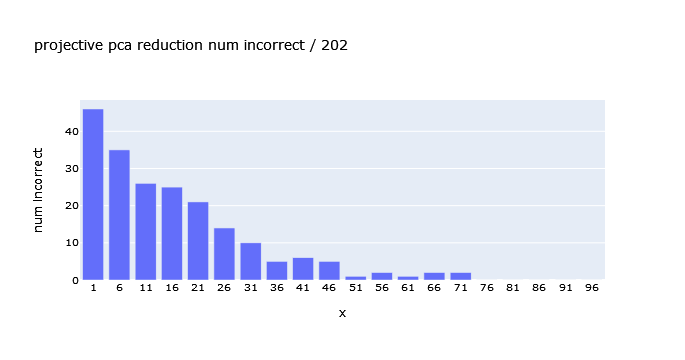

10.82138442993164 11.173883438110352
12.736701965332031 10.217185974121094
8.846115112304688 6.645937442779541
7.833235740661621 6.569667816162109
11.275167465209961 9.637931823730469
11.706157684326172 10.110433578491211
10.820472717285156 9.33121109008789
9.343393325805664 9.4407377243042
7.741237640380859 5.295808792114258
11.029853820800781 7.26798152923584
9.24068832397461 8.79992389678955
12.335310935974121 7.3508076667785645
11.4617919921875 10.812494277954102
12.249700546264648 9.514029502868652
9.796886444091797 9.914495468139648
10.353769302368164 8.812589645385742
13.758966445922852 9.780296325683594
11.305784225463867 10.323810577392578
7.346553325653076 5.561267852783203
6.7610931396484375 6.760856628417969
12.463811874389648 11.240272521972656
11.58830738067627 11.424102783203125
11.935590744018555 9.477813720703125
10.57258415222168 9.6211519241333
12.906749725341797 9.574055671691895
12.236769676208496 10.673309326171875
8.085566520690918 9.532452583312988
11.3673925399

In [28]:

data_x = pca_sizes[:len(replace_corrects)]
data_y = []
for i in range(len(replace_corrects)):
    replace_diff = -torch.tensor(replace_corrects[i]) + torch.tensor(replace_replaces[i])
    n_correct = torch.sum(replace_diff > 0)
    data_y.append(n_correct)
    print(f'pca {data_x[i]} replace min diff {torch.min(replace_diff)} max diff {torch.max(replace_diff)} avg diff {torch.mean(replace_diff)}')

data_y = torch.tensor(data_y, device=model.cfg.device)


def bar_chart(data, x_labels, y_label, title, font_size=None):
    import pandas as pd
    import plotly.express as px
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()

bar_chart(data_y, x_labels=data_x, y_label='num incorrect', title=f'projective pca reduction num incorrect / {len(replace_replaces[0])}', font_size=10)

for i in range(len(replace_corrects[0])):
    print(replace_corrects[0][i], replace_replaces[0][i])
#patched_diff = -torch.tensor(patched_correct) + torch.tensor(patched_replace)

#print(n_correct_matrix)


In [30]:
print(len(name_tokens))
pca = PCA(n_components=pca_dim)
pca.fit(X)

209


In [52]:
name_points = []
pca_dim = 90


from collections import defaultdict

X_proj = np.concatenate([X,np.ones((X.shape[0], 1))], axis=1)


for component_1 in range(0, pca_dim, 2):
    component_2 = component_1 + 1
    grouped_by_answers = defaultdict(lambda: [])
    grouped_by_template = defaultdict(lambda: [])
        
    for i in range(X.shape[0]):
        answer_tok = data.correct[i][0].item()
        template = data.data[i][1].item()
        components = pca.transform(X_proj[i].reshape(1, -1)).reshape(-1)
        grouped_by_answers[answer_tok].append((components[component_1], components[component_2]))
        grouped_by_template[template].append((components[component_1], components[component_2]))
    
    from matplotlib import pyplot as plt
    import matplotlib.cm as cm
    grouped_by_answers = sorted(list(grouped_by_answers.items()))[:20]
    colors = cm.rainbow(np.linspace(0, 1, len(grouped_by_answers)))
    
    for (answer_i, points), c in zip(grouped_by_answers, colors):
        x = np.array([point[0] for point in points])
        y = np.array([point[1] for point in points])
        plt.scatter(x, y, color=c)
    plt.title(f'components {component_1} {component_2} colored by name')
    plt.savefig(f'{component_1} {component_2} name.png')
    plt.show()
    
    
    grouped_by_template = sorted(list(grouped_by_template.items()))
    colors = cm.rainbow(np.linspace(0, 1, len(grouped_by_template)))
    
    for (answer_i, points), c in zip(grouped_by_template, colors):
        x = np.array([point[0] for point in points])
        y = np.array([point[1] for point in points])
        plt.scatter(x, y, color=c)
    plt.title(f'components {component_1} {component_2} colored by template')
    plt.savefig(f'{component_1} {component_2} template.png')
    plt.show()

KeyboardInterrupt: 

In [38]:
for x in ABC_TEMPLATES:
    print(x)

Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Afterwards [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
When [NAME], [NAME] and [NAME] arrived at the [PLACE], [NAME] and [NAME] gave a [OBJECT] to
Friends [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to


In [92]:
#X_proj = np.concatenate([X,np.ones((X.shape[0], 1))], axis=1)
from concept_erasure import LeaceEraser
from collections import defaultdict
X_data_by_name = defaultdict(lambda: [])
Y_data_by_name = defaultdict(lambda: [])
X_proj = np.concatenate([X,np.ones((X.shape[0], 1))], axis=1)

# gather positive examples
print("get positive examples")
for i in range(X_proj.shape[0]):
    answer_tok = data.correct[i][0].item()
    X_data_by_name[answer_tok].append(X_proj[i])
    Y_data_by_name[answer_tok].append([1.0,0.0])

# gather negative examples
print("get negative examples")
for answer, X_data in X_data_by_name.items():
    num_points = len(X_data)
    while len(X_data) < num_points*2:
        random_data_i = random.randint(0, X_proj.shape[0]-1)
        random_data_answer = data.correct[random_data_i][0].item()
        if random_data_answer != answer:
            X_data.append(X_proj[random_data_i])
            Y_data_by_name[answer].append([0.0, 1.0])

# shuffle data
print("shuffle data")
for answer in list(X_data_by_name.keys()):
    inds = list(range(len(X_data_by_name[answer])))
    random.shuffle(inds)
    X_data_by_name[answer] = [X_data_by_name[answer][i] for i in inds]
    Y_data_by_name[answer] = [Y_data_by_name[answer][i] for i in inds]

print("training erasers")
# train leace
name_erasers = {}


for answer in tqdm(list(X_data_by_name.keys())):
    Xd, Yd = X_data_by_name[answer], Y_data_by_name[answer]
    Xd = torch.tensor(Xd, device=model.cfg.device)
    Yd = torch.tensor(Yd, device=model.cfg.device)
    print(Xd.size())
    name_erasers[answer] = LeaceEraser.fit(Xd, Yd)

print("done")


get positive examples
get negative examples
shuffle data
training erasers


  0%|                                                                                           | 0/209 [00:00<?, ?it/s]

torch.Size([1184, 2049])


  0%|▍                                                                                  | 1/209 [00:00<02:00,  1.72it/s]

torch.Size([1176, 2049])


  1%|▊                                                                                  | 2/209 [00:01<01:57,  1.76it/s]

torch.Size([1072, 2049])


  1%|█▏                                                                                 | 3/209 [00:01<01:54,  1.80it/s]

torch.Size([1072, 2049])


  2%|█▌                                                                                 | 4/209 [00:02<01:52,  1.82it/s]

torch.Size([1180, 2049])


  2%|█▉                                                                                 | 5/209 [00:02<01:52,  1.81it/s]

torch.Size([1136, 2049])


  3%|██▍                                                                                | 6/209 [00:03<01:51,  1.82it/s]

torch.Size([1208, 2049])


  3%|██▊                                                                                | 7/209 [00:03<01:54,  1.76it/s]

torch.Size([1096, 2049])


  4%|███▏                                                                               | 8/209 [00:04<01:52,  1.78it/s]

torch.Size([1124, 2049])


  4%|███▌                                                                               | 9/209 [00:05<01:55,  1.73it/s]

torch.Size([1300, 2049])


  5%|███▉                                                                              | 10/209 [00:05<01:55,  1.72it/s]

torch.Size([1220, 2049])


  5%|████▎                                                                             | 11/209 [00:06<01:54,  1.73it/s]

torch.Size([1064, 2049])


  6%|████▋                                                                             | 12/209 [00:06<01:51,  1.76it/s]

torch.Size([1172, 2049])


  6%|█████                                                                             | 13/209 [00:07<01:51,  1.76it/s]

torch.Size([1104, 2049])


  7%|█████▍                                                                            | 14/209 [00:07<01:53,  1.71it/s]

torch.Size([1140, 2049])


  7%|█████▉                                                                            | 15/209 [00:08<01:51,  1.74it/s]

torch.Size([1140, 2049])


  8%|██████▎                                                                           | 16/209 [00:09<01:49,  1.76it/s]

torch.Size([1212, 2049])


  8%|██████▋                                                                           | 17/209 [00:09<01:48,  1.76it/s]

torch.Size([1172, 2049])


  9%|███████                                                                           | 18/209 [00:10<01:47,  1.77it/s]

torch.Size([1152, 2049])


  9%|███████▍                                                                          | 19/209 [00:10<01:46,  1.79it/s]

torch.Size([1156, 2049])


 10%|███████▊                                                                          | 20/209 [00:11<01:45,  1.79it/s]

torch.Size([1108, 2049])


 10%|████████▏                                                                         | 21/209 [00:11<01:44,  1.80it/s]

torch.Size([1192, 2049])


 11%|████████▋                                                                         | 22/209 [00:12<01:48,  1.73it/s]

torch.Size([1244, 2049])


 11%|█████████                                                                         | 23/209 [00:13<01:51,  1.67it/s]

torch.Size([1204, 2049])


 11%|█████████▍                                                                        | 24/209 [00:13<01:48,  1.70it/s]

torch.Size([1184, 2049])


 12%|█████████▊                                                                        | 25/209 [00:14<01:47,  1.72it/s]

torch.Size([1200, 2049])


 12%|██████████▏                                                                       | 26/209 [00:14<01:45,  1.73it/s]

torch.Size([1220, 2049])


 13%|██████████▌                                                                       | 27/209 [00:15<01:44,  1.74it/s]

torch.Size([1196, 2049])


 13%|██████████▉                                                                       | 28/209 [00:15<01:43,  1.75it/s]

torch.Size([1160, 2049])


 14%|███████████▍                                                                      | 29/209 [00:16<01:42,  1.76it/s]

torch.Size([1160, 2049])


 14%|███████████▊                                                                      | 30/209 [00:17<01:40,  1.77it/s]

torch.Size([1180, 2049])


 15%|████████████▏                                                                     | 31/209 [00:17<01:40,  1.78it/s]

torch.Size([1080, 2049])


 15%|████████████▌                                                                     | 32/209 [00:18<01:43,  1.70it/s]

torch.Size([1164, 2049])


 16%|████████████▉                                                                     | 33/209 [00:18<01:41,  1.73it/s]

torch.Size([1160, 2049])


 16%|█████████████▎                                                                    | 34/209 [00:19<01:40,  1.74it/s]

torch.Size([1184, 2049])


 17%|█████████████▋                                                                    | 35/209 [00:19<01:40,  1.73it/s]

torch.Size([1180, 2049])


 17%|██████████████                                                                    | 36/209 [00:20<01:41,  1.70it/s]

torch.Size([1180, 2049])


 18%|██████████████▌                                                                   | 37/209 [00:21<01:41,  1.70it/s]

torch.Size([1236, 2049])


 18%|██████████████▉                                                                   | 38/209 [00:21<01:39,  1.71it/s]

torch.Size([1228, 2049])


 19%|███████████████▎                                                                  | 39/209 [00:22<01:38,  1.72it/s]

torch.Size([1152, 2049])


 19%|███████████████▋                                                                  | 40/209 [00:22<01:37,  1.74it/s]

torch.Size([1240, 2049])


 20%|████████████████                                                                  | 41/209 [00:23<01:38,  1.70it/s]

torch.Size([1092, 2049])


 20%|████████████████▍                                                                 | 42/209 [00:24<01:36,  1.73it/s]

torch.Size([1124, 2049])


 21%|████████████████▊                                                                 | 43/209 [00:24<01:35,  1.74it/s]

torch.Size([1156, 2049])


 21%|█████████████████▎                                                                | 44/209 [00:25<01:35,  1.72it/s]

torch.Size([1280, 2049])


 22%|█████████████████▋                                                                | 45/209 [00:25<01:39,  1.66it/s]

torch.Size([1124, 2049])


 22%|██████████████████                                                                | 46/209 [00:26<01:36,  1.70it/s]

torch.Size([1136, 2049])


 22%|██████████████████▍                                                               | 47/209 [00:27<01:37,  1.67it/s]

torch.Size([1172, 2049])


 23%|██████████████████▊                                                               | 48/209 [00:27<01:36,  1.67it/s]

torch.Size([1144, 2049])


 23%|███████████████████▏                                                              | 49/209 [00:28<01:34,  1.70it/s]

torch.Size([1124, 2049])


 24%|███████████████████▌                                                              | 50/209 [00:28<01:31,  1.74it/s]

torch.Size([1156, 2049])


 24%|████████████████████                                                              | 51/209 [00:29<01:29,  1.76it/s]

torch.Size([1204, 2049])


 25%|████████████████████▍                                                             | 52/209 [00:29<01:28,  1.77it/s]

torch.Size([1208, 2049])


 25%|████████████████████▊                                                             | 53/209 [00:30<01:28,  1.77it/s]

torch.Size([1064, 2049])


 26%|█████████████████████▏                                                            | 54/209 [00:30<01:26,  1.80it/s]

torch.Size([1140, 2049])


 26%|█████████████████████▌                                                            | 55/209 [00:31<01:25,  1.80it/s]

torch.Size([996, 2049])


 27%|█████████████████████▉                                                            | 56/209 [00:32<01:23,  1.83it/s]

torch.Size([1140, 2049])


 27%|██████████████████████▎                                                           | 57/209 [00:32<01:24,  1.80it/s]

torch.Size([1144, 2049])


 28%|██████████████████████▊                                                           | 58/209 [00:33<01:23,  1.80it/s]

torch.Size([1292, 2049])


 28%|███████████████████████▏                                                          | 59/209 [00:33<01:24,  1.77it/s]

torch.Size([1072, 2049])


 29%|███████████████████████▌                                                          | 60/209 [00:34<01:23,  1.79it/s]

torch.Size([1060, 2049])


 29%|███████████████████████▉                                                          | 61/209 [00:34<01:21,  1.81it/s]

torch.Size([1100, 2049])


 30%|████████████████████████▎                                                         | 62/209 [00:35<01:20,  1.82it/s]

torch.Size([1212, 2049])


 30%|████████████████████████▋                                                         | 63/209 [00:35<01:20,  1.81it/s]

torch.Size([1160, 2049])


 31%|█████████████████████████                                                         | 64/209 [00:36<01:20,  1.81it/s]

torch.Size([1072, 2049])


 31%|█████████████████████████▌                                                        | 65/209 [00:37<01:19,  1.82it/s]

torch.Size([1088, 2049])


 32%|█████████████████████████▉                                                        | 66/209 [00:37<01:18,  1.83it/s]

torch.Size([1160, 2049])


 32%|██████████████████████████▎                                                       | 67/209 [00:38<01:17,  1.82it/s]

torch.Size([1156, 2049])


 33%|██████████████████████████▋                                                       | 68/209 [00:38<01:17,  1.82it/s]

torch.Size([1244, 2049])


 33%|███████████████████████████                                                       | 69/209 [00:39<01:17,  1.80it/s]

torch.Size([1132, 2049])


 33%|███████████████████████████▍                                                      | 70/209 [00:39<01:16,  1.81it/s]

torch.Size([1292, 2049])


 34%|███████████████████████████▊                                                      | 71/209 [00:40<01:19,  1.75it/s]

torch.Size([1228, 2049])


 34%|████████████████████████████▏                                                     | 72/209 [00:41<01:18,  1.75it/s]

torch.Size([1328, 2049])


 35%|████████████████████████████▋                                                     | 73/209 [00:41<01:18,  1.74it/s]

torch.Size([2196, 2049])


 35%|█████████████████████████████                                                     | 74/209 [00:42<01:24,  1.60it/s]

torch.Size([1096, 2049])


 36%|█████████████████████████████▍                                                    | 75/209 [00:42<01:20,  1.66it/s]

torch.Size([1204, 2049])


 36%|█████████████████████████████▊                                                    | 76/209 [00:43<01:18,  1.70it/s]

torch.Size([1228, 2049])


 37%|██████████████████████████████▏                                                   | 77/209 [00:44<01:16,  1.72it/s]

torch.Size([1108, 2049])


 37%|██████████████████████████████▌                                                   | 78/209 [00:44<01:16,  1.71it/s]

torch.Size([1176, 2049])


 38%|██████████████████████████████▉                                                   | 79/209 [00:45<01:15,  1.72it/s]

torch.Size([1108, 2049])


 38%|███████████████████████████████▍                                                  | 80/209 [00:45<01:13,  1.76it/s]

torch.Size([1196, 2049])


 39%|███████████████████████████████▊                                                  | 81/209 [00:46<01:13,  1.74it/s]

torch.Size([1048, 2049])


 39%|████████████████████████████████▏                                                 | 82/209 [00:46<01:11,  1.77it/s]

torch.Size([1068, 2049])


 40%|████████████████████████████████▌                                                 | 83/209 [00:47<01:10,  1.80it/s]

torch.Size([1108, 2049])


 40%|████████████████████████████████▉                                                 | 84/209 [00:47<01:09,  1.80it/s]

torch.Size([1092, 2049])


 41%|█████████████████████████████████▎                                                | 85/209 [00:48<01:09,  1.79it/s]

torch.Size([1180, 2049])


 41%|█████████████████████████████████▋                                                | 86/209 [00:49<01:09,  1.78it/s]

torch.Size([1112, 2049])


 42%|██████████████████████████████████▏                                               | 87/209 [00:49<01:07,  1.80it/s]

torch.Size([1120, 2049])


 42%|██████████████████████████████████▌                                               | 88/209 [00:50<01:08,  1.77it/s]

torch.Size([1092, 2049])


 43%|██████████████████████████████████▉                                               | 89/209 [00:50<01:09,  1.72it/s]

torch.Size([1140, 2049])


 43%|███████████████████████████████████▎                                              | 90/209 [00:51<01:08,  1.75it/s]

torch.Size([1100, 2049])


 44%|███████████████████████████████████▋                                              | 91/209 [00:51<01:06,  1.77it/s]

torch.Size([1144, 2049])


 44%|████████████████████████████████████                                              | 92/209 [00:52<01:08,  1.72it/s]

torch.Size([1064, 2049])


 44%|████████████████████████████████████▍                                             | 93/209 [00:53<01:06,  1.76it/s]

torch.Size([1056, 2049])


 45%|████████████████████████████████████▉                                             | 94/209 [00:53<01:04,  1.79it/s]

torch.Size([1080, 2049])


 45%|█████████████████████████████████████▎                                            | 95/209 [00:54<01:06,  1.72it/s]

torch.Size([1228, 2049])


 46%|█████████████████████████████████████▋                                            | 96/209 [00:54<01:05,  1.73it/s]

torch.Size([1064, 2049])


 46%|██████████████████████████████████████                                            | 97/209 [00:55<01:03,  1.76it/s]

torch.Size([1212, 2049])


 47%|██████████████████████████████████████▍                                           | 98/209 [00:55<01:03,  1.76it/s]

torch.Size([1092, 2049])


 47%|██████████████████████████████████████▊                                           | 99/209 [00:56<01:01,  1.77it/s]

torch.Size([1184, 2049])


 48%|██████████████████████████████████████▊                                          | 100/209 [00:57<01:01,  1.78it/s]

torch.Size([1140, 2049])


 48%|███████████████████████████████████████▏                                         | 101/209 [00:57<01:00,  1.78it/s]

torch.Size([2212, 2049])


 49%|███████████████████████████████████████▌                                         | 102/209 [00:58<01:06,  1.62it/s]

torch.Size([1132, 2049])


 49%|███████████████████████████████████████▉                                         | 103/209 [00:58<01:03,  1.67it/s]

torch.Size([1208, 2049])


 50%|████████████████████████████████████████▎                                        | 104/209 [00:59<01:02,  1.67it/s]

torch.Size([1224, 2049])


 50%|████████████████████████████████████████▋                                        | 105/209 [01:00<01:01,  1.69it/s]

torch.Size([976, 2049])


 51%|█████████████████████████████████████████                                        | 106/209 [01:00<00:59,  1.72it/s]

torch.Size([1044, 2049])


 51%|█████████████████████████████████████████▍                                       | 107/209 [01:01<01:00,  1.69it/s]

torch.Size([1064, 2049])


 52%|█████████████████████████████████████████▊                                       | 108/209 [01:01<01:00,  1.67it/s]

torch.Size([1108, 2049])


 52%|██████████████████████████████████████████▏                                      | 109/209 [01:02<01:00,  1.65it/s]

torch.Size([1208, 2049])


 53%|██████████████████████████████████████████▋                                      | 110/209 [01:03<01:01,  1.61it/s]

torch.Size([1244, 2049])


 53%|███████████████████████████████████████████                                      | 111/209 [01:03<00:59,  1.65it/s]

torch.Size([1120, 2049])


 54%|███████████████████████████████████████████▍                                     | 112/209 [01:04<00:58,  1.67it/s]

torch.Size([1144, 2049])


 54%|███████████████████████████████████████████▊                                     | 113/209 [01:04<00:56,  1.71it/s]

torch.Size([1224, 2049])


 55%|████████████████████████████████████████████▏                                    | 114/209 [01:05<00:55,  1.72it/s]

torch.Size([1184, 2049])


 55%|████████████████████████████████████████████▌                                    | 115/209 [01:06<00:54,  1.71it/s]

torch.Size([1096, 2049])


 56%|████████████████████████████████████████████▉                                    | 116/209 [01:06<00:53,  1.75it/s]

torch.Size([1112, 2049])


 56%|█████████████████████████████████████████████▎                                   | 117/209 [01:07<00:53,  1.71it/s]

torch.Size([1036, 2049])


 56%|█████████████████████████████████████████████▋                                   | 118/209 [01:07<00:53,  1.69it/s]

torch.Size([1072, 2049])


 57%|██████████████████████████████████████████████                                   | 119/209 [01:08<00:53,  1.68it/s]

torch.Size([1280, 2049])


 57%|██████████████████████████████████████████████▌                                  | 120/209 [01:08<00:52,  1.70it/s]

torch.Size([1156, 2049])


 58%|██████████████████████████████████████████████▉                                  | 121/209 [01:09<00:51,  1.72it/s]

torch.Size([1136, 2049])


 58%|███████████████████████████████████████████████▎                                 | 122/209 [01:10<00:50,  1.74it/s]

torch.Size([1172, 2049])


 59%|███████████████████████████████████████████████▋                                 | 123/209 [01:10<00:49,  1.74it/s]

torch.Size([1112, 2049])


 59%|████████████████████████████████████████████████                                 | 124/209 [01:11<00:48,  1.77it/s]

torch.Size([1060, 2049])


 60%|████████████████████████████████████████████████▍                                | 125/209 [01:11<00:47,  1.76it/s]

torch.Size([1216, 2049])


 60%|████████████████████████████████████████████████▊                                | 126/209 [01:12<00:47,  1.74it/s]

torch.Size([1136, 2049])


 61%|█████████████████████████████████████████████████▏                               | 127/209 [01:13<00:48,  1.69it/s]

torch.Size([1020, 2049])


 61%|█████████████████████████████████████████████████▌                               | 128/209 [01:13<00:46,  1.74it/s]

torch.Size([1068, 2049])


 62%|█████████████████████████████████████████████████▉                               | 129/209 [01:14<00:45,  1.76it/s]

torch.Size([1072, 2049])


 62%|██████████████████████████████████████████████████▍                              | 130/209 [01:14<00:44,  1.79it/s]

torch.Size([1048, 2049])


 63%|██████████████████████████████████████████████████▊                              | 131/209 [01:15<00:43,  1.80it/s]

torch.Size([1168, 2049])


 63%|███████████████████████████████████████████████████▏                             | 132/209 [01:15<00:42,  1.79it/s]

torch.Size([1108, 2049])


 64%|███████████████████████████████████████████████████▌                             | 133/209 [01:16<00:42,  1.80it/s]

torch.Size([932, 2049])


 64%|███████████████████████████████████████████████████▉                             | 134/209 [01:16<00:40,  1.83it/s]

torch.Size([1008, 2049])


 65%|████████████████████████████████████████████████████▎                            | 135/209 [01:17<00:40,  1.81it/s]

torch.Size([1084, 2049])


 65%|████████████████████████████████████████████████████▋                            | 136/209 [01:17<00:40,  1.82it/s]

torch.Size([1180, 2049])


 66%|█████████████████████████████████████████████████████                            | 137/209 [01:18<00:40,  1.78it/s]

torch.Size([980, 2049])


 66%|█████████████████████████████████████████████████████▍                           | 138/209 [01:19<00:39,  1.80it/s]

torch.Size([1116, 2049])


 67%|█████████████████████████████████████████████████████▊                           | 139/209 [01:19<00:38,  1.81it/s]

torch.Size([1164, 2049])


 67%|██████████████████████████████████████████████████████▎                          | 140/209 [01:20<00:38,  1.81it/s]

torch.Size([1032, 2049])


 67%|██████████████████████████████████████████████████████▋                          | 141/209 [01:20<00:37,  1.83it/s]

torch.Size([1260, 2049])


 68%|███████████████████████████████████████████████████████                          | 142/209 [01:21<00:37,  1.78it/s]

torch.Size([1104, 2049])


 68%|███████████████████████████████████████████████████████▍                         | 143/209 [01:21<00:38,  1.70it/s]

torch.Size([1140, 2049])


 69%|███████████████████████████████████████████████████████▊                         | 144/209 [01:22<00:39,  1.66it/s]

torch.Size([1076, 2049])


 69%|████████████████████████████████████████████████████████▏                        | 145/209 [01:23<00:39,  1.63it/s]

torch.Size([1140, 2049])


 70%|████████████████████████████████████████████████████████▌                        | 146/209 [01:23<00:37,  1.68it/s]

torch.Size([1088, 2049])


 70%|████████████████████████████████████████████████████████▉                        | 147/209 [01:24<00:35,  1.72it/s]

torch.Size([1200, 2049])


 71%|█████████████████████████████████████████████████████████▎                       | 148/209 [01:24<00:34,  1.74it/s]

torch.Size([1088, 2049])


 71%|█████████████████████████████████████████████████████████▋                       | 149/209 [01:25<00:34,  1.76it/s]

torch.Size([1124, 2049])


 72%|██████████████████████████████████████████████████████████▏                      | 150/209 [01:26<00:33,  1.74it/s]

torch.Size([1104, 2049])


 72%|██████████████████████████████████████████████████████████▌                      | 151/209 [01:26<00:33,  1.73it/s]

torch.Size([1120, 2049])


 73%|██████████████████████████████████████████████████████████▉                      | 152/209 [01:27<00:32,  1.76it/s]

torch.Size([1228, 2049])


 73%|███████████████████████████████████████████████████████████▎                     | 153/209 [01:27<00:31,  1.76it/s]

torch.Size([1168, 2049])


 74%|███████████████████████████████████████████████████████████▋                     | 154/209 [01:28<00:31,  1.76it/s]

torch.Size([1164, 2049])


 74%|████████████████████████████████████████████████████████████                     | 155/209 [01:28<00:31,  1.70it/s]

torch.Size([1260, 2049])


 75%|████████████████████████████████████████████████████████████▍                    | 156/209 [01:29<00:31,  1.69it/s]

torch.Size([1008, 2049])


 75%|████████████████████████████████████████████████████████████▊                    | 157/209 [01:30<00:29,  1.75it/s]

torch.Size([1160, 2049])


 76%|█████████████████████████████████████████████████████████████▏                   | 158/209 [01:30<00:28,  1.76it/s]

torch.Size([1092, 2049])


 76%|█████████████████████████████████████████████████████████████▌                   | 159/209 [01:31<00:28,  1.76it/s]

torch.Size([1160, 2049])


 77%|██████████████████████████████████████████████████████████████                   | 160/209 [01:31<00:27,  1.77it/s]

torch.Size([1120, 2049])


 77%|██████████████████████████████████████████████████████████████▍                  | 161/209 [01:32<00:26,  1.78it/s]

torch.Size([1128, 2049])


 78%|██████████████████████████████████████████████████████████████▊                  | 162/209 [01:32<00:26,  1.79it/s]

torch.Size([1140, 2049])


 78%|███████████████████████████████████████████████████████████████▏                 | 163/209 [01:33<00:26,  1.73it/s]

torch.Size([1068, 2049])


 78%|███████████████████████████████████████████████████████████████▌                 | 164/209 [01:33<00:25,  1.77it/s]

torch.Size([1164, 2049])


 79%|███████████████████████████████████████████████████████████████▉                 | 165/209 [01:34<00:24,  1.78it/s]

torch.Size([1164, 2049])


 79%|████████████████████████████████████████████████████████████████▎                | 166/209 [01:35<00:25,  1.71it/s]

torch.Size([1044, 2049])


 80%|████████████████████████████████████████████████████████████████▋                | 167/209 [01:35<00:23,  1.76it/s]

torch.Size([1104, 2049])


 80%|█████████████████████████████████████████████████████████████████                | 168/209 [01:36<00:23,  1.78it/s]

torch.Size([1172, 2049])


 81%|█████████████████████████████████████████████████████████████████▍               | 169/209 [01:36<00:22,  1.78it/s]

torch.Size([1164, 2049])


 81%|█████████████████████████████████████████████████████████████████▉               | 170/209 [01:37<00:21,  1.79it/s]

torch.Size([1052, 2049])


 82%|██████████████████████████████████████████████████████████████████▎              | 171/209 [01:37<00:21,  1.81it/s]

torch.Size([1128, 2049])


 82%|██████████████████████████████████████████████████████████████████▋              | 172/209 [01:38<00:20,  1.79it/s]

torch.Size([1084, 2049])


 83%|███████████████████████████████████████████████████████████████████              | 173/209 [01:39<00:20,  1.75it/s]

torch.Size([1096, 2049])


 83%|███████████████████████████████████████████████████████████████████▍             | 174/209 [01:39<00:19,  1.78it/s]

torch.Size([1164, 2049])


 84%|███████████████████████████████████████████████████████████████████▊             | 175/209 [01:40<00:19,  1.73it/s]

torch.Size([1060, 2049])


 84%|████████████████████████████████████████████████████████████████████▏            | 176/209 [01:40<00:18,  1.75it/s]

torch.Size([1124, 2049])


 85%|████████████████████████████████████████████████████████████████████▌            | 177/209 [01:41<00:18,  1.76it/s]

torch.Size([1184, 2049])


 85%|████████████████████████████████████████████████████████████████████▉            | 178/209 [01:41<00:18,  1.72it/s]

torch.Size([1072, 2049])


 86%|█████████████████████████████████████████████████████████████████████▎           | 179/209 [01:42<00:17,  1.75it/s]

torch.Size([960, 2049])


 86%|█████████████████████████████████████████████████████████████████████▊           | 180/209 [01:43<00:16,  1.80it/s]

torch.Size([1180, 2049])


 87%|██████████████████████████████████████████████████████████████████████▏          | 181/209 [01:43<00:15,  1.79it/s]

torch.Size([1196, 2049])


 87%|██████████████████████████████████████████████████████████████████████▌          | 182/209 [01:44<00:15,  1.78it/s]

torch.Size([1128, 2049])


 88%|██████████████████████████████████████████████████████████████████████▉          | 183/209 [01:44<00:14,  1.75it/s]

torch.Size([1168, 2049])


 88%|███████████████████████████████████████████████████████████████████████▎         | 184/209 [01:45<00:14,  1.75it/s]

torch.Size([1184, 2049])


 89%|███████████████████████████████████████████████████████████████████████▋         | 185/209 [01:45<00:13,  1.74it/s]

torch.Size([1188, 2049])


 89%|████████████████████████████████████████████████████████████████████████         | 186/209 [01:46<00:13,  1.72it/s]

torch.Size([1052, 2049])


 89%|████████████████████████████████████████████████████████████████████████▍        | 187/209 [01:47<00:12,  1.71it/s]

torch.Size([1148, 2049])


 90%|████████████████████████████████████████████████████████████████████████▊        | 188/209 [01:47<00:12,  1.74it/s]

torch.Size([1164, 2049])


 90%|█████████████████████████████████████████████████████████████████████████▏       | 189/209 [01:48<00:11,  1.74it/s]

torch.Size([1096, 2049])


 91%|█████████████████████████████████████████████████████████████████████████▋       | 190/209 [01:48<00:10,  1.77it/s]

torch.Size([1084, 2049])


 91%|██████████████████████████████████████████████████████████████████████████       | 191/209 [01:49<00:10,  1.79it/s]

torch.Size([1204, 2049])


 92%|██████████████████████████████████████████████████████████████████████████▍      | 192/209 [01:49<00:09,  1.78it/s]

torch.Size([1028, 2049])


 92%|██████████████████████████████████████████████████████████████████████████▊      | 193/209 [01:50<00:08,  1.81it/s]

torch.Size([1132, 2049])


 93%|███████████████████████████████████████████████████████████████████████████▏     | 194/209 [01:50<00:08,  1.82it/s]

torch.Size([1156, 2049])


 93%|███████████████████████████████████████████████████████████████████████████▌     | 195/209 [01:51<00:07,  1.81it/s]

torch.Size([1120, 2049])


 94%|███████████████████████████████████████████████████████████████████████████▉     | 196/209 [01:52<00:07,  1.82it/s]

torch.Size([1180, 2049])


 94%|████████████████████████████████████████████████████████████████████████████▎    | 197/209 [01:52<00:06,  1.79it/s]

torch.Size([1080, 2049])


 95%|████████████████████████████████████████████████████████████████████████████▋    | 198/209 [01:53<00:06,  1.69it/s]

torch.Size([1164, 2049])


 95%|█████████████████████████████████████████████████████████████████████████████    | 199/209 [01:53<00:05,  1.68it/s]

torch.Size([1180, 2049])


 96%|█████████████████████████████████████████████████████████████████████████████▌   | 200/209 [01:54<00:05,  1.71it/s]

torch.Size([1088, 2049])


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 201/209 [01:55<00:04,  1.75it/s]

torch.Size([1028, 2049])


 97%|██████████████████████████████████████████████████████████████████████████████▎  | 202/209 [01:55<00:04,  1.69it/s]

torch.Size([1132, 2049])


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 203/209 [01:56<00:03,  1.72it/s]

torch.Size([1184, 2049])


 98%|███████████████████████████████████████████████████████████████████████████████  | 204/209 [01:56<00:02,  1.74it/s]

torch.Size([1112, 2049])


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 205/209 [01:57<00:02,  1.76it/s]

torch.Size([1048, 2049])


 99%|███████████████████████████████████████████████████████████████████████████████▊ | 206/209 [01:57<00:01,  1.78it/s]

torch.Size([1252, 2049])


 99%|████████████████████████████████████████████████████████████████████████████████▏| 207/209 [01:58<00:01,  1.75it/s]

torch.Size([1188, 2049])


100%|████████████████████████████████████████████████████████████████████████████████▌| 208/209 [01:59<00:00,  1.76it/s]

torch.Size([1036, 2049])


100%|█████████████████████████████████████████████████████████████████████████████████| 209/209 [01:59<00:00,  1.75it/s]

done


In [134]:
import random
replace_corrects = []
replace_replaces = []
original_corrects = []
original_replaces = []
#pca_sizes = []
#X_proj = np.concatenate([X,np.ones((X.shape[0], 1))], axis=1)
#print(X_proj[:,-1])

# subtract to erase
# add to add
def apply_eraser(eraser, x):
    delta = x - eraser.bias
    diff = (delta @ eraser.proj_right.mH) @ eraser.proj_left.mH
    return x - diff

def invert_eraser(eraser, x):
    # (AB)^-1 = B^-1 A^-1
    eye = torch.eye(x.size()[0], device=model.cfg.device, dtype=eraser.proj_left.dtype)
    
    #Inv = torch.linalg.inv(eraser.proj_right.mH @ eraser.proj_left.mH)
    #Inv = torch.linalg.pinv(eye-eraser.proj_right.mH @ eraser.proj_left.mH)
    # approximation to the inverse
    res = eye
    prod = eraser.proj_right.mH @ eraser.proj_left.mH
    for i in range(40):
        res += prod
        prod = prod @ eraser.proj_right.mH @ eraser.proj_left.mH
    #print(f"inverse {Inv}")
    bA = (eraser.bias @ eraser.proj_right.mH) @ eraser.proj_left.mH
    return (x-bA)@res

for _ in range(1):
    original_correct = []
    original_replace = []
    replace_correct = []
    replace_replace = []
    print(f"layer {layer}")
    name_bases = [0]
    for position_1, name_basis in enumerate(name_bases):
        num_found = 0
        while True:            
            data_i = random.choice(list(range(10000)))
            
            import random
            from functools import partial
        
            data_i = (data_i // 2)*2
            patched_i = data_i + 1
            
            data_tokens = data.data[data_i]
            corrupted_tokens = data.data[data_i+1]
            answer_tok = data.correct[data_i][0].item()
            answer = model.to_str_tokens(torch.tensor([answer_tok]))[0]
            replace_tok = data.correct[patched_i][0].item()
            replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
            '''
            others = model.to_str_tokens(data.incorrect[data_i])
            print("prompt", model.to_str_tokens(data_tokens))
            print("answer", answer)
            print("other names", others)
            replace_name = model.to_str_tokens(answer)[0]
            while True:
                replace_tok = random.choice(list(name_tokens))
                replace_name = model.to_str_tokens(torch.tensor([replace_tok]))[0]
                if not replace_name in [answer] + others:
                    break
            '''
            #print("got replace name", repr(replace_name))
            #print("logits before replace")
            last_token_pos = data.last_token_position[data_i]
            
            def replace_hook(
                x,
                hook,
                position,
                answer_name_tok,
                replace_name_tok,
            ):
                B,L,E = x.size()
                for b in range(B):
                    veco = torch.concatenate([x[b,position], torch.tensor([1.0], device=model.cfg.device)])
                    vec = apply_eraser(name_erasers[answer_name_tok], veco)
                    vec2 = invert_eraser(name_erasers[replace_name_tok], vec)
                    invert_diff = vec2 - vec
                    vec = vec + invert_diff*100
                    # we can do vec + diff to get vec2
                    # instead we will do vec - diff to do inverse
                    #vec = vec2
                    
                    #print(vec)
                    #print("done")
                    x[b,position] = vec[:-1]

                    #add_ones = np.concatenate([vec.detach().cpu().numpy(), np.array([1.0])], axis=0).reshape(1,-1)
                    #pcad = pca.transform(add_ones)
                    #x[b,position] = torch.tensor(pca.inverse_transform(pcad), device=model.cfg.device).reshape(-1)[:-1]
                    '''
                    coords = name_basis.map_to_coords(vec/torch.linalg.norm(vec, ord=2))
                    C = len(name_tok_to_class)
                    sorted = torch.argsort(coords[:C])
                    print(coords[sorted][-5:])
                    maxi = torch.argmax(coords[:C])
                    print(f"predict {maxi} {coords[maxi]}")
                    print(f"answer {name_tok_to_class[answer_name_tok]} replace {name_tok_to_class[replace_name_tok]}")
                    coords[name_tok_to_class[answer_name_tok]] = -0.0692
                    coords[name_tok_to_class[replace_name_tok]] = 0.0692
                    maxi = torch.argmax(coords[:C])
                    print(f"now predict {maxi} {coords[maxi]}")
                    patched_vec = name_basis.map_from_coords(coords)
                    print(f"orig norm {torch.linalg.norm(vec, ord=2)} patched norm {torch.linalg.norm(patched_vec, ord=2)}")
                    patched_veco = patched_vec / torch.linalg.norm(patched_vec, ord=2) * torch.linalg.norm(vec, ord=2)
                    print(f"now orig norm {torch.linalg.norm(vec, ord=2)} patched norm {torch.linalg.norm(patched_vec, ord=2)}")
                    coords2 = name_basis.map_to_coords(patched_vec)
                    sorted = torch.argsort(coords2[:C])
                    print("predict2", coords2[sorted][-5:])
                    maxi = torch.argmax(coords2[:C])
                    print(f"predict2 {maxi} {coords2[maxi]}")
                    '''
                    #x[b,position] = patched_veco
                return x
            
            answer_positions = []
            for name_i in range(len(data_name_positions)):
                position = data_name_positions[name_i][data_i]
                if data_tokens[position].item() == answer_tok:
                    answer_positions.append((name_i, position))
            
            #print("answer positions", answer_positions)
            hooks = []
            bad = False
            for name_i, position in answer_positions:
                if not name_i == position_1 or len(answer_positions) > 2:
                    bad = True
                
                hooks.append((
                    f'blocks.{layer}.hook_ssm_input', 
                    partial(replace_hook,
                            position=position+1,
                            answer_name_tok=answer_tok,
                            replace_name_tok=replace_tok,
                    )
                ))
            if bad:
                continue
            else:
                num_found += 1
            
            logits = model(data_tokens.view(1,-1), **model_kwargs)
            #print(f"answer {repr(answer)} logit {logits[0,last_token_pos,answer_tok]}")
            #print(f"replace {repr(replace_name)} logit {logits[0,last_token_pos,replace_tok]}")
            original_correct.append(logits[0,last_token_pos,answer_tok].item())
            original_replace.append(logits[0,last_token_pos,replace_tok].item())
            if num_found % 10 == 0:
                print(num_found)
            logits_modified = model.run_with_hooks(data_tokens.view(1, -1), fwd_hooks=hooks, **model_kwargs)
            #print(logits_modified.size())
            #print(f"modified answer {repr(answer)} logit {logits_modified[0,last_token_pos,answer_tok]}")
            #print(f"modified replace {repr(replace_name)} logit {logits_modified[0,last_token_pos,replace_tok]}")
            replace_correct.append(logits_modified[0,last_token_pos,answer_tok].item())
            replace_replace.append(logits_modified[0,last_token_pos,replace_tok].item())
            hooks = []
            for name_i, position in answer_positions:
                hooks.append((
                    f'blocks.{layer}.hook_ssm_input', 
                    partial(replace_hook,
                            position=position+1,
                            answer_name_tok=replace_tok,
                            replace_name_tok=answer_tok,
                    )
                ))
            
            logits = model(corrupted_tokens.view(1,-1), **model_kwargs)
            #print(f"answer {repr(answer)} logit {logits[0,last_token_pos,answer_tok]}")
            #print(f"replace {repr(replace_name)} logit {logits[0,last_token_pos,replace_tok]}")
            original_correct.append(logits[0,last_token_pos,replace_tok].item())
            original_replace.append(logits[0,last_token_pos,answer_tok].item())
            
            logits_modified = model.run_with_hooks(corrupted_tokens.view(1, -1), fwd_hooks=hooks, **model_kwargs)

            replace_correct.append(logits_modified[0,last_token_pos,replace_tok].item())
            replace_replace.append(logits_modified[0,last_token_pos,answer_tok].item())
            
            
            #logits_patched, acts = model.run_with_cache(data.data[patched_i].view(1,-1), names_filter=[hook])
            #print(f"patched answer {repr(answer)} logit {logits_patched[0,last_token_pos,answer_tok]}")
            #print(f"patched replace {repr(replace_name)} logit {logits_patched[0,last_token_pos,replace_tok]}")
            #patched_correct.append(logits_patched[0,last_token_pos,answer_tok].item())
            #patched_replace.append(logits_patched[0,last_token_pos,replace_tok].item())
            if num_found > 100:
                break
        break
    original_corrects.append(original_correct)
    original_replaces.append(original_replace)
    replace_corrects.append(replace_correct)
    replace_replaces.append(replace_replace)



layer 39
10
20
30
40
50
60
70
80
90
100


In [135]:


for i in range(len(replace_corrects)):
    replace_diff = -torch.tensor(replace_corrects[i]) + torch.tensor(replace_replaces[i])
    n_correct = torch.sum(replace_diff > 0)
    print(f"{n_correct}/{len(replace_corrects[i])}")
    print(f'replace min diff {torch.min(replace_diff)} max diff {torch.max(replace_diff)} avg diff {torch.mean(replace_diff)}')

    for j in range(len(replace_corrects[i])):
        print("h")
        print(original_corrects[i][j], original_replaces[i][j])
        print(replace_corrects[i][j], replace_replaces[i][j])

96/202
replace min diff -68.55792999267578 max diff 69.87189483642578 avg diff -0.19875283539295197
h
16.470701217651367 9.71561050415039
-5.661073684692383 -22.156082153320312
h
14.580031394958496 9.408432006835938
0.48569345474243164 6.747767448425293
h
14.380048751831055 7.109065055847168
-2.442127227783203 -24.21950912475586
h
16.272052764892578 7.420269966125488
-7.698086738586426 62.173805236816406
h
14.879524230957031 9.761422157287598
-3.2463455200195312 25.89336395263672
h
14.439093589782715 5.619184970855713
8.848220825195312 -33.423301696777344
h
14.669663429260254 8.600264549255371
2.081355094909668 -1.9556349515914917
h
15.520383834838867 7.870769500732422
1.4222896099090576 22.22512435913086
h
17.11648941040039 11.07115650177002
-10.067371368408203 -39.855567932128906
h
14.599285125732422 9.929826736450195
-6.593348979949951 -6.830587863922119
h
16.378326416015625 11.30602741241455
5.956884860992432 -38.610435485839844
h
17.24477195739746 12.21163272857666
4.2309827804565